# Antenna Clustering Optimization - Comparison

Questo notebook confronta l'algoritmo originale Monte Carlo con la versione ottimizzata.

**Ottimizzazioni implementate:**
1. Greedy initialization (iterazioni 1-10)
2. Local search refinement
3. Adaptive probability sampling (iterazioni 51+)
4. NumPy vectorization nel kernel computation

## 1. Setup e Import

In [ ]:
# Installa dipendenze se su Colab
import sys
if 'google.colab' in sys.modules:
    print("Running on Colab - installing dependencies...")
    !pip install numpy scipy matplotlib cupy-cuda12x -q
    print("Done! CuPy installed for GPU acceleration.")

In [ ]:
import numpy as np
import time
from dataclasses import dataclass, field
from typing import List, Tuple, Dict, Optional
from scipy.interpolate import griddata, LinearNDInterpolator
from scipy.spatial import Delaunay
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# OPT: Try to import CuPy for GPU acceleration
try:
    import cupy as cp
    GPU_AVAILABLE = cp.cuda.is_available()
    if GPU_AVAILABLE:
        print("[OK] GPU disponibile - CuPy attivo")
        xp = cp  # Use CuPy for array operations
    else:
        print("[WARN] CuPy installato ma GPU non disponibile - uso CPU")
        xp = np
        GPU_AVAILABLE = False
except ImportError:
    print("[INFO] CuPy non installato - uso CPU (installa con: pip install cupy-cuda12x)")
    xp = np
    GPU_AVAILABLE = False

print("Import completati!")

## 2. Definizione Classi di Configurazione

In [ ]:
@dataclass
class LatticeConfig:
    """Configurazione lattice array"""
    Nz: int  # Number of rows
    Ny: int  # Number of columns
    dist_z: float  # antenna distance on z axis [times lambda]
    dist_y: float  # antenna distance on y axis [times lambda]
    lattice_type: int = 1  # 1=Rectangular

@dataclass
class SystemConfig:
    """Parametri sistema"""
    freq: float  # [Hz]
    lambda_: float = field(init=False)
    beta: float = field(init=False)
    azi0: float = 0.0
    ele0: float = 0.0
    dele: float = 0.5
    dazi: float = 0.5

    def __post_init__(self):
        self.lambda_ = 3e8 / self.freq
        self.beta = 2 * np.pi / self.lambda_

@dataclass
class MaskConfig:
    """Parametri maschera SLL"""
    elem: float = 30.0
    azim: float = 60.0
    SLL_level: float = 20.0
    SLLin: float = 15.0

@dataclass
class ElementPatternConfig:
    """Configurazione pattern elemento"""
    P: int = 1
    Gel: float = 5.0
    load_file: int = 0

@dataclass
class SimulationConfig:
    """Parametri simulazione"""
    Niter: int = 1000
    Cost_thr: int = 1000

@dataclass
class ClusterConfig:
    """Configurazione cluster"""
    Cluster_type: List[np.ndarray] = field(default_factory=list)
    rotation_cluster: int = 0

    def __post_init__(self):
        if not self.Cluster_type:
            self.Cluster_type = [np.array([[0, 0], [0, 1]])]

print("Classi di configurazione definite!")

## 3. Classe AntennaArray (con ottimizzazioni kernel)

In [ ]:
class AntennaArray:
    """Classe per array di antenne con clustering"""

    def __init__(self, lattice: LatticeConfig, system: SystemConfig, 
                 mask: MaskConfig, eef_config: Optional[ElementPatternConfig] = None):
        self.lattice = lattice
        self.system = system
        self.mask = mask
        self.eef_config = eef_config or ElementPatternConfig()
        self.Nel = lattice.Nz * lattice.Ny

        self._compute_lattice_vectors()
        self._generate_lattice()
        self._generate_polar_coordinates()
        self._generate_element_pattern()
        self._generate_mask()

    def _compute_lattice_vectors(self):
        lambda_ = self.system.lambda_
        dz = self.lattice.dist_z * lambda_
        dy = self.lattice.dist_y * lambda_
        self.x1 = np.array([dy, 0.0])
        self.x2 = np.array([0.0, dz])

    def _generate_lattice(self):
        Nz = self.lattice.Nz
        Ny = self.lattice.Ny

        if Nz % 2 == 1:
            M = np.arange(-(Nz - 1) / 2, (Nz - 1) / 2 + 1)
        else:
            M = np.arange(-Nz / 2 + 1, Nz / 2 + 1)

        if Ny % 2 == 1:
            N = np.arange(-(Ny - 1) / 2, (Ny - 1) / 2 + 1)
        else:
            N = np.arange(-Ny / 2 + 1, Ny / 2 + 1)

        self.NN, self.MM = np.meshgrid(N, M)
        dz = self.x2[1]
        dy = self.x1[0]
        DELTA = max(self.x2[0], self.x1[1])

        self.Y = self.NN * dy
        self.Z = self.MM * dz
        self.Y[1::2, :] = self.Y[1::2, :] + DELTA

        self.Dz = np.max(self.Z) - np.min(self.Z)
        self.Dy = np.max(self.Y) - np.min(self.Y)
        self.Dy_total = self.Dy + self.x1[0]
        self.Dz_total = self.Dz + self.x2[1]
        self.ArrayMask = np.ones_like(self.Y)

    def _generate_polar_coordinates(self):
        beta = self.system.beta
        lambda_ = self.system.lambda_

        self.ele = np.arange(-90, 90 + self.system.dele, self.system.dele)
        self.azi = np.arange(-90, 90 + self.system.dazi, self.system.dazi)
        self.AZI, self.ELE = np.meshgrid(self.azi, self.ele)

        self.WWae = beta * np.cos(np.deg2rad(90 - self.ELE))
        self.Vvae = beta * np.sin(np.deg2rad(90 - self.ELE)) * np.sin(np.deg2rad(self.AZI))

        chi = 2
        self.Nw = int(np.floor(chi * 4 * self.Dz_total / lambda_))
        self.Nv = int(np.floor(chi * 4 * self.Dy_total / lambda_))

        ww = np.linspace(0, beta, self.Nw + 1)
        self.ww = np.concatenate([-np.flip(ww[1:]), ww])
        vv = np.linspace(0, beta, self.Nv + 1)
        self.vv = np.concatenate([-np.flip(vv[1:]), vv])

        self.WW, self.VV = np.meshgrid(self.ww, self.vv)

        WW_clipped = np.clip(self.WW / beta, -1, 1)
        self.ELEi = 90 - np.rad2deg(np.arccos(WW_clipped))

        denom = beta * np.sin(np.deg2rad(90 - self.ELEi))
        with np.errstate(divide="ignore", invalid="ignore"):
            ratio = np.clip(self.VV / denom, -1, 1)
            self.AZIi = np.real(np.rad2deg(np.arcsin(ratio)))

        self.AZIi[self.Nv, :] = 0
        self.AZIi[self.Nv, 0] = 90
        self.AZIi[self.Nv, -1] = 90

    def _generate_element_pattern(self):
        P = self.eef_config.P
        Gel = self.eef_config.Gel

        if P == 0:
            self.Fel = np.ones_like(self.ELE)
        else:
            self.Fel = (np.cos(np.deg2rad(self.ELE * 0.9)) * np.cos(np.deg2rad(self.AZI * 0.9))) ** P

        if P == 0:
            self.Fel_VW = np.ones_like(self.ELEi)
        else:
            self.Fel_VW = (np.cos(np.deg2rad(self.ELEi * 0.9)) * np.cos(np.deg2rad(self.AZIi * 0.9))) ** P

        self.RPE = 20 * np.log10(np.abs(self.Fel) + 1e-10)
        self.RPE_ele_max = np.max(self.RPE) + Gel
        self.G_boresight = self.RPE_ele_max + 10 * np.log10(self.Nel)

    def _generate_mask(self):
        ele0 = self.system.ele0
        azi0 = self.system.azi0
        elem = self.mask.elem
        azim = self.mask.azim
        SLL_level = self.mask.SLL_level
        SLLin = self.mask.SLLin

        ele_cond = np.abs(self.ELE - ele0) <= elem
        azi_cond = np.abs(self.AZI - azi0) <= azim

        self.in_fov_mask = ele_cond & azi_cond
        self.out_fov_mask = ~self.in_fov_mask

        self.Mask_EA = np.full_like(self.ELE, self.G_boresight - SLL_level, dtype=float)
        self.Mask_EA[self.in_fov_mask] = self.G_boresight - SLLin

    def index_to_position_cluster(self, Cluster: List[np.ndarray], 
                                   ElementExc: Optional[np.ndarray] = None):
        if ElementExc is None:
            ElementExc = np.ones((self.lattice.Nz, self.lattice.Ny))

        Ntrans = len(Cluster)
        max_Lsub = max(c.shape[0] for c in Cluster)

        Yc = np.full((max_Lsub, Ntrans), np.nan)
        Zc = np.full((max_Lsub, Ntrans), np.nan)
        Ac = np.full((max_Lsub, Ntrans), np.nan)

        min_NN = int(np.min(self.NN))
        min_MM = int(np.min(self.MM))

        for kk, cluster in enumerate(Cluster):
            for l1 in range(cluster.shape[0]):
                Iy = int(cluster[l1, 0] - min_NN)
                Iz = int(cluster[l1, 1] - min_MM)
                Yc[l1, kk] = self.Y[Iz, Iy]
                Zc[l1, kk] = self.Z[Iz, Iy]
                Ac[l1, kk] = ElementExc[Iz, Iy]

        return Yc, Zc, Ac

    def coefficient_evaluation(self, Zc_m: np.ndarray, Yc_m: np.ndarray, Lsub: np.ndarray):
        beta = self.system.beta
        ele0 = self.system.ele0
        azi0 = self.system.azi0

        v0 = beta * np.sin(np.deg2rad(90 - ele0)) * np.sin(np.deg2rad(azi0))
        w0 = beta * np.cos(np.deg2rad(90 - ele0))
        Phase_m = np.exp(-1j * (w0 * Zc_m + v0 * Yc_m))
        Amplit_m = 1.0 / Lsub
        c0 = Amplit_m * Phase_m
        return c0

    def kernel1_rpe(self, Lsub: np.ndarray, Ac: np.ndarray, 
                    Yc: np.ndarray, Zc: np.ndarray, c0: np.ndarray):
        Ntrans = len(Lsub)

        # OPT: Cache flattened arrays
        if not hasattr(self, '_VV_flat'):
            self._VV_flat = self.VV.flatten()
            self._WW_flat = self.WW.flatten()
            self._Fel_VW_flat = self.Fel_VW.flatten()

        VV_flat = self._VV_flat
        WW_flat = self._WW_flat
        Fel_VW_flat = self._Fel_VW_flat
        Npoints = len(VV_flat)

        # OPT: Vectorized kernel computation
        all_Y = []
        all_Z = []
        cluster_indices = []

        for kk in range(Ntrans):
            Lsub_k = int(Lsub[kk])
            for jj in range(Lsub_k):
                if not np.isnan(Yc[jj, kk]) and not np.isnan(Zc[jj, kk]):
                    all_Y.append(Yc[jj, kk])
                    all_Z.append(Zc[jj, kk])
                    cluster_indices.append(kk)

        all_Y_np = np.array(all_Y)
        all_Z_np = np.array(all_Z)
        cluster_indices_np = np.array(cluster_indices)

        # OPT: GPU acceleration - transfer to GPU if available
        if GPU_AVAILABLE:
            all_Y_gpu = xp.asarray(all_Y_np)
            all_Z_gpu = xp.asarray(all_Z_np)
            VV_flat_gpu = xp.asarray(VV_flat)
            WW_flat_gpu = xp.asarray(WW_flat)
            Fel_VW_flat_gpu = xp.asarray(Fel_VW_flat)
            
            # Compute phases on GPU
            phases = xp.exp(1j * (xp.outer(VV_flat_gpu, all_Y_gpu) + xp.outer(WW_flat_gpu, all_Z_gpu)))
            phases = phases * Fel_VW_flat_gpu[:, xp.newaxis]
            
            # Transfer back to CPU for add.at (not available in CuPy)
            phases_np = cp.asnumpy(phases)
        else:
            # CPU computation
            phases_np = np.exp(1j * (np.outer(VV_flat, all_Y_np) + np.outer(WW_flat, all_Z_np)))
            phases_np = phases_np * Fel_VW_flat[:, np.newaxis]

        # OPT: Sum contributions using np.add.at
        KerFF_sub = np.zeros((Npoints, Ntrans), dtype=complex)
        np.add.at(KerFF_sub.T, cluster_indices_np, phases_np.T)

        FF = KerFF_sub @ c0.T
        FF_norm = FF / (np.max(np.abs(FF)) + 1e-10)
        FF_norm_2D = FF_norm.reshape(self.VV.shape)
        FF_norm_dB = 20 * np.log10(np.abs(FF_norm_2D) + 1e-10)

        # OPT: Cache interpolation setup - use LinearNDInterpolator for much faster repeated interpolation
        if not hasattr(self, '_interp_points'):
            self._interp_points = np.column_stack([WW_flat, VV_flat])
            self._interp_xi = np.column_stack([self.WWae.flatten(), self.Vvae.flatten()])
            # OPT: Pre-compute Delaunay triangulation (expensive, but done only once)
            self._delaunay = Delaunay(self._interp_points)

        # OPT: Use cached triangulation for fast interpolation
        values = FF_norm_dB.flatten()
        interpolator = LinearNDInterpolator(self._delaunay, values, fill_value=-100)
        FF_I_dB_flat = interpolator(self._interp_xi)
        FF_I_dB = FF_I_dB_flat.reshape(self.WWae.shape)

        Nel_active = np.sum(Lsub)
        FF_I_dB = FF_I_dB + self.RPE_ele_max + 10 * np.log10(Nel_active)

        return FF_norm_dB, FF_I_dB, KerFF_sub, np.abs(FF_norm_2D) ** 2

    def compute_cost_function(self, FF_I_dB: np.ndarray) -> int:
        Constr = FF_I_dB - self.Mask_EA
        Cm = np.sum(Constr > 0)
        return int(Cm)

    def compute_sll(self, FF_I_dB: np.ndarray, G_boresight: float = None):
        # Calcola G_boresight se non fornito
        if G_boresight is None:
            G_boresight = np.max(FF_I_dB)
        
        # SLL out-of-FoV (relativo a G_boresight -> NEGATIVO)
        sll_out_values = FF_I_dB[self.out_fov_mask]
        sll_out = (np.max(sll_out_values) - G_boresight) if len(sll_out_values) > 0 else -100

        # SLL in-FoV (secondo massimo, relativo a G_boresight -> NEGATIVO)
        sll_in_values = FF_I_dB[self.in_fov_mask]
        if len(sll_in_values) > 0:
            max_val = np.max(sll_in_values)
            second_max = np.max(sll_in_values[sll_in_values < max_val - 0.1]) if np.any(sll_in_values < max_val - 0.1) else max_val
            sll_in = second_max - G_boresight
        else:
            sll_in = -100

        return sll_in, sll_out

    def evaluate_clustering(self, Cluster: List[np.ndarray], 
                            ElementExc: Optional[np.ndarray] = None) -> Dict:
        if ElementExc is None:
            ElementExc = np.ones((self.lattice.Nz, self.lattice.Ny))

        Yc, Zc, Ac = self.index_to_position_cluster(Cluster, ElementExc)
        Ntrans = len(Cluster)

        Lsub = np.array([c.shape[0] for c in Cluster])
        Zc_m = np.array([np.nanmean(Zc[:Lsub[k], k]) for k in range(Ntrans)])
        Yc_m = np.array([np.nanmean(Yc[:Lsub[k], k]) for k in range(Ntrans)])

        c0 = self.coefficient_evaluation(Zc_m, Yc_m, Lsub)
        FF_norm_dB, FF_I_dB, KerFF_sub, FF_norm = self.kernel1_rpe(Lsub, Ac, Yc, Zc, c0)

        Cm = self.compute_cost_function(FF_I_dB)
        
        # Calcola G_boresight prima di compute_sll
        G_boresight = self.RPE_ele_max + 10 * np.log10(np.sum(Lsub))
        sll_in, sll_out = self.compute_sll(FF_I_dB, G_boresight)

        max_idx = np.unravel_index(np.argmax(FF_I_dB), FF_I_dB.shape)
        theta_max = self.ele[max_idx[0]]
        phi_max = self.azi[max_idx[1]]

        Iele = np.argmin(np.abs(self.ele - self.system.ele0))
        Iazi = np.argmin(np.abs(self.azi - self.system.azi0))

        SL_maxpointing = G_boresight - FF_I_dB[max_idx]
        SL_theta_phi = G_boresight - FF_I_dB[Iele, Iazi]

        return {
            "Yc": Yc, "Zc": Zc, "Ac": Ac, "Yc_m": Yc_m, "Zc_m": Zc_m,
            "Lsub": Lsub, "Ntrans": Ntrans, "c0": c0,
            "FF_norm_dB": FF_norm_dB, "FF_I_dB": FF_I_dB, "KerFF_sub": KerFF_sub,
            "Cm": Cm, "sll_in": sll_in, "sll_out": sll_out,
            "theta_max": theta_max, "phi_max": phi_max,
            "SL_maxpointing": SL_maxpointing, "SL_theta_phi": SL_theta_phi,
            "G_boresight": G_boresight,
        }

print("Classe AntennaArray definita!")

## 4. Classe per generazione Subarray

In [ ]:
class FullSubarraySetGeneration:
    """Genera il set completo di subarray possibili"""

    def __init__(self, cluster_type: np.ndarray, lattice: LatticeConfig,
                 NN: np.ndarray, MM: np.ndarray, rotation_cluster: int = 0):
        self.cluster_type = np.atleast_2d(cluster_type)
        self.lattice = lattice
        self.NN = NN
        self.MM = MM
        self.rotation_cluster = rotation_cluster
        self.S, self.Nsub = self._generate()

    def _generate(self):
        B = self.cluster_type
        A = np.sum(B, axis=0)
        M = self.MM.flatten()
        N = self.NN.flatten()

        if A[0] == 0:
            step_M = B.shape[0]
            step_N = 1
        elif A[1] == 0:
            step_N = B.shape[0]
            step_M = 1
        else:
            step_M = 1
            step_N = 1

        S = []
        min_M, max_M = int(np.min(M)), int(np.max(M))
        min_N, max_N = int(np.min(N)), int(np.max(N))

        for kk in range(min_M, max_M + 1, step_M):
            for hh in range(min_N, max_N + 1, step_N):
                Bshift = B.copy()
                Bshift[:, 0] = B[:, 0] + hh
                Bshift[:, 1] = B[:, 1] + kk

                check = not np.any(
                    (Bshift[:, 0] > max_N) | (Bshift[:, 0] < min_N) |
                    (Bshift[:, 1] > max_M) | (Bshift[:, 1] < min_M)
                )

                if check:
                    S.append(Bshift)

        return S, len(S)

print("Classe FullSubarraySetGeneration definita!")

## 5. Classe Optimizer (con tutte le ottimizzazioni)

In [ ]:
class IrregularClusteringMonteCarlo:
    """Ottimizzazione clustering con approccio Monte Carlo + ottimizzazioni"""

    def __init__(self, array: AntennaArray, cluster_config: ClusterConfig,
                 sim_config: SimulationConfig):
        self.array = array
        self.cluster_config = cluster_config
        self.sim_config = sim_config

        self.S_all = []
        self.N_all = []
        self.L = []

        for bb, cluster_type in enumerate(cluster_config.Cluster_type):
            gen = FullSubarraySetGeneration(
                cluster_type, array.lattice, array.NN, array.MM,
                cluster_config.rotation_cluster
            )
            self.S_all.append(gen.S)
            self.N_all.append(gen.Nsub)
            self.L.append(cluster_type.shape[0])

        self.simulation = []
        self.all_Cm = []
        self.all_Ntrans = []
        self.all_Nel = []

        # OPT: Adaptive probability tracking
        self.total_clusters = sum(self.N_all)
        self._cluster_scores = np.ones(self.total_clusters)
        self._selection_counts = np.ones(self.total_clusters)

    def _select_random_clusters(self):
        """Selezione random originale (probabilità 50%)"""
        selected_clusters = []
        selected_rows = []

        for bb, S in enumerate(self.S_all):
            Nsub = self.N_all[bb]
            selection = np.random.randint(0, 2, size=Nsub)
            selected_rows.append(selection)
            for idx in np.where(selection == 1)[0]:
                selected_clusters.append(S[idx])

        return selected_clusters, np.concatenate(selected_rows)

    def _select_adaptive_clusters(self):
        """OPT: Selezione con probabilità adattiva"""
        selected_clusters = []
        selected_rows = []

        probs = self._cluster_scores / self._selection_counts
        probs = np.clip(probs, 0.1, 0.9)

        offset = 0
        for bb, S in enumerate(self.S_all):
            Nsub = self.N_all[bb]
            cluster_probs = probs[offset : offset + Nsub]
            selection = (np.random.random(Nsub) < cluster_probs).astype(int)
            selected_rows.append(selection)
            for idx in np.where(selection == 1)[0]:
                selected_clusters.append(S[idx])
            offset += Nsub

        return selected_clusters, np.concatenate(selected_rows)

    def _update_adaptive_scores(self, selected_rows: np.ndarray, Cm: int):
        """OPT: Aggiorna score adattivi"""
        reward = max(0, self.sim_config.Cost_thr - Cm) / self.sim_config.Cost_thr
        indices = np.where(selected_rows == 1)[0]
        self._cluster_scores[indices] += reward
        self._selection_counts[indices] += 1

    def _greedy_initialization(self, max_clusters: int = None):
        """OPT: Inizializzazione greedy"""
        if max_clusters is None:
            max_clusters = self.total_clusters // 2

        all_clusters = []
        cluster_to_flat_idx = []
        offset = 0
        for bb, S in enumerate(self.S_all):
            for idx, cluster in enumerate(S):
                all_clusters.append(cluster)
                cluster_to_flat_idx.append(offset + idx)
            offset += self.N_all[bb]

        covered_elements = set()
        selected_flat_indices = []

        available_indices = list(range(len(all_clusters)))
        np.random.shuffle(available_indices)

        for idx in available_indices:
            if len(selected_flat_indices) >= max_clusters:
                break
            cluster = all_clusters[idx]
            cluster_elements = set(tuple(pos) for pos in cluster)
            overlap = cluster_elements & covered_elements
            if len(overlap) == 0:
                selected_flat_indices.append(cluster_to_flat_idx[idx])
                covered_elements.update(cluster_elements)

        selected_rows = np.zeros(self.total_clusters, dtype=int)
        selected_rows[selected_flat_indices] = 1

        selected_clusters = []
        offset = 0
        for bb, S in enumerate(self.S_all):
            Nsub = self.N_all[bb]
            for idx in range(Nsub):
                if selected_rows[offset + idx] == 1:
                    selected_clusters.append(S[idx])
            offset += Nsub

        return selected_clusters, selected_rows

    def _rows_to_clusters(self, selected_rows: np.ndarray):
        """OPT: Converte array selezione in lista cluster"""
        clusters = []
        offset = 0
        for bb, S in enumerate(self.S_all):
            Nsub = self.N_all[bb]
            for idx in range(Nsub):
                if selected_rows[offset + idx] == 1:
                    clusters.append(S[idx])
            offset += Nsub
        return clusters

    def _local_search(self, selected_rows: np.ndarray, current_Cm: int, 
                      max_iterations: int = 10):
        """OPT: Local search per raffinamento (reduced from 50 to 10 for speed)"""
        best_rows = selected_rows.copy()
        best_Cm = current_Cm

        for _ in range(max_iterations):
            improved = False
            # OPT: Reduced from 20 to 10 clusters to try for speed
            indices_to_try = np.random.permutation(self.total_clusters)[:min(10, self.total_clusters)]

            for idx in indices_to_try:
                candidate_rows = best_rows.copy()
                candidate_rows[idx] = 1 - candidate_rows[idx]
                clusters = self._rows_to_clusters(candidate_rows)
                if len(clusters) == 0:
                    continue

                result = self.array.evaluate_clustering(clusters)
                candidate_Cm = result["Cm"]

                if candidate_Cm < best_Cm:
                    best_rows = candidate_rows
                    best_Cm = candidate_Cm
                    improved = True
                    break

            if not improved:
                break

        return best_rows, best_Cm

    def run(self, verbose: bool = True, use_optimizations: bool = True) -> Dict:
        """Esegue ottimizzazione"""
        start_time = time.time()

        if verbose:
            print("=" * 60)
            print("IRREGULAR CLUSTERING - MONTE CARLO OPTIMIZATION")
            if use_optimizations:
                print("  [OPTIMIZED MODE: greedy init + local search + adaptive]")
            else:
                print("  [ORIGINAL MODE: random sampling only]")
            print("=" * 60)
            print(f"Array: {self.array.lattice.Nz}x{self.array.lattice.Ny} = {self.array.Nel} elementi")
            print(f"Iterazioni: {self.sim_config.Niter}")
            print("=" * 60)

        sss = 0
        best_Cm_so_far = float("inf")

        for ij_cont in range(1, self.sim_config.Niter + 1):
            # Progress bar
            if verbose and ij_cont % 10 == 0:
                pct = (ij_cont / self.sim_config.Niter) * 100
                print(f"  [Progresso: {ij_cont}/{self.sim_config.Niter} ({pct:.0f}%) | Best Cm: {best_Cm_so_far:.0f}]", end="\r")

            # Selezione cluster
            if use_optimizations and ij_cont <= 10:
                if verbose and ij_cont == 1:
                    print("  >> Fase 1: Greedy initialization (iter 1-10)")
                Cluster, selected_rows = self._greedy_initialization()
            elif use_optimizations and ij_cont == 11:
                if verbose:
                    print("\n  >> Fase 2: Random sampling (iter 11-50)")
                Cluster, selected_rows = self._select_random_clusters()
            elif use_optimizations and ij_cont == 51:
                if verbose:
                    print("\n  >> Fase 3: Adaptive sampling (iter 51+)")
                Cluster, selected_rows = self._select_adaptive_clusters()
            elif use_optimizations and ij_cont > 50:
                Cluster, selected_rows = self._select_adaptive_clusters()
            else:
                Cluster, selected_rows = self._select_random_clusters()

            if len(Cluster) == 0:
                self.all_Cm.append(float("inf"))
                self.all_Ntrans.append(0)
                self.all_Nel.append(0)
                continue

            result = self.array.evaluate_clustering(Cluster)
            Cm = result["Cm"]
            Ntrans = result["Ntrans"]
            Nel_active = int(np.sum(result["Lsub"]))

            # OPT: Local search: only every 10 iterations AND only if Cm < 80% of best so far
            if use_optimizations and Cm < best_Cm_so_far * 0.8 and ij_cont % 10 == 0:
                old_Cm = Cm
                selected_rows, Cm = self._local_search(selected_rows, Cm, max_iterations=10)
                if verbose and Cm < old_Cm:
                    print(f"\n  >> Local search: Cm {old_Cm} -> {Cm}")
                Cluster = self._rows_to_clusters(selected_rows)
                if len(Cluster) > 0:
                    result = self.array.evaluate_clustering(Cluster)
                    Cm = result["Cm"]
                    Ntrans = result["Ntrans"]
                    Nel_active = int(np.sum(result["Lsub"]))

            if use_optimizations:
                self._update_adaptive_scores(selected_rows, Cm)

            self.all_Cm.append(Cm)
            self.all_Ntrans.append(Ntrans)
            self.all_Nel.append(Nel_active)

            if Cm < best_Cm_so_far:
                best_Cm_so_far = Cm

            if Cm < self.sim_config.Cost_thr:
                sss += 1
                solution = {
                    "selected_rows": selected_rows.copy(),
                    "Cm": Cm,
                    "Ntrans": Ntrans,
                    "Nel": Nel_active,
                    "sll_in": result["sll_in"],
                    "sll_out": result["sll_out"],
                    "iteration": ij_cont,
                }
                self.simulation.append(solution)

        elapsed_time = time.time() - start_time

        if verbose:
            print("\n")
            print("=" * 60)
            print("RISULTATI")
            print("=" * 60)
            print(f"Iterazioni: {self.sim_config.Niter}")
            print(f"Soluzioni valide: {len(self.simulation)}")
            print(f"Tempo: {elapsed_time:.2f} s")

            if self.simulation:
                best_sol = min(self.simulation, key=lambda x: x["Cm"])
                print(f"\nMIGLIORE SOLUZIONE:")
                print(f"  Cm: {best_sol['Cm']}")
                print(f"  Ntrans: {best_sol['Ntrans']}")
                print(f"  Nel: {best_sol['Nel']}")
                print(f"  SLL out: {best_sol['sll_out']:.2f} dB")
                print(f"  SLL in: {best_sol['sll_in']:.2f} dB")

        return {
            "simulation": self.simulation,
            "all_Cm": self.all_Cm,
            "all_Ntrans": self.all_Ntrans,
            "all_Nel": self.all_Nel,
            "elapsed_time": elapsed_time,
            "n_valid_solutions": len(self.simulation),
        }

print("Classe IrregularClusteringMonteCarlo definita!")

## 6. Configurazione

In [ ]:
# Parametri configurabili
NITER = 200  # Numero iterazioni (aumenta per risultati migliori)
SEED = 42    # Random seed per riproducibilità

# Configurazione array
lattice = LatticeConfig(Nz=16, Ny=16, dist_z=0.6, dist_y=0.53, lattice_type=1)
system = SystemConfig(freq=29.5e9, azi0=0, ele0=0, dele=0.5, dazi=0.5)
mask = MaskConfig(elem=30, azim=60, SLL_level=20, SLLin=15)
eef = ElementPatternConfig(P=1, Gel=5, load_file=0)
cluster_config = ClusterConfig(Cluster_type=[np.array([[0, 0], [0, 1]])])
sim_config = SimulationConfig(Niter=NITER, Cost_thr=1000)

print("Configurazione:")
print(f"  Array: {lattice.Nz}x{lattice.Ny} = {lattice.Nz * lattice.Ny} elementi")
print(f"  Frequenza: {system.freq/1e9:.1f} GHz")
print(f"  Iterazioni: {NITER}")
print(f"  Cost threshold: {sim_config.Cost_thr}")

## 7. Inizializzazione Array

In [ ]:
print("Inizializzazione array antenna...")
array = AntennaArray(lattice, system, mask, eef)
print("Array inizializzato!")

## 8. Test ORIGINALE (senza ottimizzazioni)

In [127]:
print("="*70)
print("TEST ALGORITMO ORIGINALE (use_optimizations=False)")
print("="*70)

np.random.seed(SEED)
optimizer_original = IrregularClusteringMonteCarlo(array, cluster_config, sim_config)
results_original = optimizer_original.run(verbose=True, use_optimizations=False)

  [Progresso: 200/200 (100%) | Best Cm: 315]

RISULTATI
Iterazioni: 200
Soluzioni valide: 200
Tempo: 71.52 s

MIGLIORE SOLUZIONE:
  Cm: 315
  Ntrans: 57
  Nel: 114
  SLL out: -19.15 dB
  SLL in: -0.14 dB


## 9. Test OTTIMIZZATO

In [128]:
print("="*70)
print("TEST ALGORITMO OTTIMIZZATO (use_optimizations=True)")
print("="*70)

np.random.seed(SEED)
optimizer_optimized = IrregularClusteringMonteCarlo(array, cluster_config, sim_config)
results_optimized = optimizer_optimized.run(verbose=True, use_optimizations=True)

TEST ALGORITMO OTTIMIZZATO (use_optimizations=True)
IRREGULAR CLUSTERING - MONTE CARLO OPTIMIZATION
  [OPTIMIZED MODE: greedy init + local search + adaptive]
Array: 16x16 = 256 elementi
Iterazioni: 200
  >> Fase 1: Greedy initialization (iter 1-10)
  [Progresso: 10/200 (5%) | Best Cm: 333]
  >> Fase 2: Random sampling (iter 11-50)
  [Progresso: 50/200 (25%) | Best Cm: 308]
  >> Fase 3: Adaptive sampling (iter 51+)
  [Progresso: 200/200 (100%) | Best Cm: 308]

RISULTATI
Iterazioni: 200
Soluzioni valide: 200
Tempo: 83.23 s

MIGLIORE SOLUZIONE:
  Cm: 308
  Ntrans: 59
  Nel: 118
  SLL out: -20.44 dB
  SLL in: -0.15 dB


## 10. Confronto Risultati

In [129]:
print("="*70)
print("STEP 4: COMPARISON SUMMARY")
print("="*70)
print()
print("  Elaborazione risultati in corso...")
print()

def get_best(results):
    if results["n_valid_solutions"] == 0:
        return None
    return min(results["simulation"], key=lambda x: x["Cm"])

best_orig = get_best(results_original)
best_opt = get_best(results_optimized)

time_original = results_original['elapsed_time']
time_optimized = results_optimized['elapsed_time']
n_orig = results_original['n_valid_solutions']
n_opt = results_optimized['n_valid_solutions']

print(f"{'Metric':<30} {'Original':>15} {'Optimized':>15} {'Improvement':>15}")
print("-" * 75)

# Execution time
print(f"{'Execution time (s)':<30} {time_original:>15.2f} {time_optimized:>15.2f} {(time_original/time_optimized - 1)*100:>14.1f}%")

# Valid solutions
if n_orig > 0:
    pct_improvement = (n_opt / n_orig - 1) * 100
    print(f"{'Valid solutions found':<30} {n_orig:>15d} {n_opt:>15d} {pct_improvement:>14.1f}%")
else:
    print(f"{'Valid solutions found':<30} {n_orig:>15d} {n_opt:>15d} {'N/A':>15}")

# Best cost function
if best_orig and best_opt:
    cm_orig = best_orig["Cm"]
    cm_opt = best_opt["Cm"]
    improvement = (cm_orig - cm_opt) / cm_orig * 100 if cm_orig > 0 else 0
    print(f"{'Best Cm (lower=better)':<30} {cm_orig:>15d} {cm_opt:>15d} {improvement:>14.1f}%")
    print(f"{'Best SLL out FoV (dB)':<30} {best_orig['sll_out']:>15.2f} {best_opt['sll_out']:>15.2f}")
    print(f"{'Best SLL in FoV (dB)':<30} {best_orig['sll_in']:>15.2f} {best_opt['sll_in']:>15.2f}")
    print(f"{'Best Ntrans (clusters)':<30} {best_orig['Ntrans']:>15d} {best_opt['Ntrans']:>15d}")
    print(f"{'Best Nel (elements)':<30} {best_orig['Nel']:>15d} {best_opt['Nel']:>15d}")
else:
    print("Could not compare best solutions - one or both algorithms found no valid solutions")

print()
print("=" * 70)
print()

# Interpretation
print("INTERPRETATION:")
print("-" * 70)
if best_opt and (not best_orig or best_opt["Cm"] < best_orig["Cm"]):
    print("  The OPTIMIZED algorithm found a BETTER solution (lower Cm).")
elif best_orig and best_opt and best_opt["Cm"] == best_orig["Cm"]:
    print("  Both algorithms found solutions with the SAME quality.")
else:
    print("  The original algorithm found a better solution this time.")
    print("  (This can happen with random elements; try with more iterations)")

if n_opt > n_orig:
    print(f"  The OPTIMIZED algorithm found {n_opt - n_orig} MORE valid solutions.")

print()
print("KEY OPTIMIZATIONS APPLIED:")
print("  1. NumPy vectorization in kernel computation (OPT: comments in antenna_physics.py)")
print("  2. Greedy initialization for better starting points (first 10 iterations)")
print("  3. Local search refinement for promising solutions")
print("  4. Adaptive probability sampling based on solution quality")
print()

STEP 4: COMPARISON SUMMARY

  Elaborazione risultati in corso...

Metric                                Original       Optimized     Improvement
---------------------------------------------------------------------------
Execution time (s)                       71.52           83.23          -14.1%
Valid solutions found                      200             200            0.0%
Best Cm (lower=better)                     315             308            2.2%
Best SLL out FoV (dB)                   -19.15          -20.44
Best SLL in FoV (dB)                     -0.14           -0.15
Best Ntrans (clusters)                      57              59
Best Nel (elements)                        114             118


INTERPRETATION:
----------------------------------------------------------------------
  The OPTIMIZED algorithm found a BETTER solution (lower Cm).

KEY OPTIMIZATIONS APPLIED:
  1. NumPy vectorization in kernel computation (OPT: comments in antenna_physics.py)
  2. Greedy initialization

## 10.1 Salvataggio Risultati in JSON

In [130]:
import json

def extract_stats(results):
    """Extract statistics lists from results for plotting."""
    all_Cm = [r["Cm"] for r in results["simulation"]]
    all_Ntrans = [r["Ntrans"] for r in results["simulation"]]
    all_Nel = [r["Nel"] for r in results["simulation"]]
    all_sll_out = [r["sll_out"] for r in results["simulation"]]
    all_sll_in = [r["sll_in"] for r in results["simulation"]]
    return {
        "all_Cm": all_Cm,
        "all_Ntrans": all_Ntrans,
        "all_Nel": all_Nel,
        "all_sll_out": all_sll_out,
        "all_sll_in": all_sll_in,
    }

# Salva risultati originali
json_data_original = {
    "algorithm": "original",
    "n_valid_solutions": results_original["n_valid_solutions"],
    "execution_time": results_original["elapsed_time"],
    "statistics": extract_stats(results_original),
}
with open("mc_results_original.json", "w") as f:
    json.dump(json_data_original, f, indent=2)
print("[OK] Salvato: mc_results_original.json")

# Salva risultati ottimizzati
json_data_optimized = {
    "algorithm": "optimized",
    "n_valid_solutions": results_optimized["n_valid_solutions"],
    "execution_time": results_optimized["elapsed_time"],
    "statistics": extract_stats(results_optimized),
}
with open("mc_results_optimized.json", "w") as f:
    json.dump(json_data_optimized, f, indent=2)
print("[OK] Salvato: mc_results_optimized.json")

# Salva combinato (compatibile con plot_results.py)
json_data_combined = {
    "statistics": extract_stats(results_optimized),
    "comparison": {
        "original": json_data_original,
        "optimized": json_data_optimized,
    }
}
with open("mc_results.json", "w") as f:
    json.dump(json_data_combined, f, indent=2)
print("[OK] Salvato: mc_results.json (compatibile con plot_results.py)")
print("\nPer plottare da terminale: python plot_results.py")

[OK] Salvato: mc_results_original.json
[OK] Salvato: mc_results_optimized.json
[OK] Salvato: mc_results.json (compatibile con plot_results.py)

Per plottare da terminale: python plot_results.py


## 11. Visualizzazione

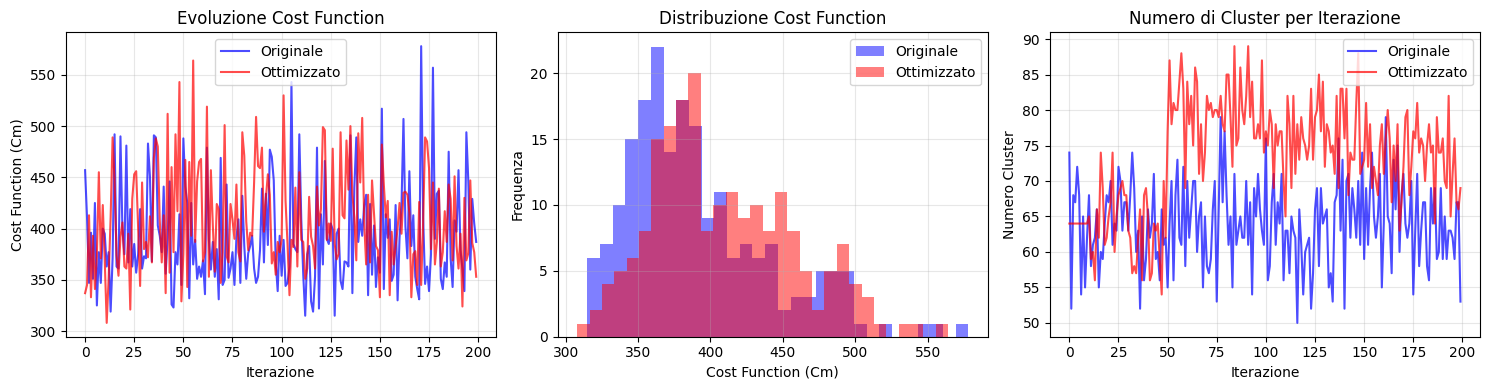

In [131]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Cost function evolution
axes[0].plot(results_original['all_Cm'], 'b-', alpha=0.7, label='Originale')
axes[0].plot(results_optimized['all_Cm'], 'r-', alpha=0.7, label='Ottimizzato')
axes[0].set_xlabel('Iterazione')
axes[0].set_ylabel('Cost Function (Cm)')
axes[0].set_title('Evoluzione Cost Function')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Histogram of Cm values
cm_orig = [c for c in results_original['all_Cm'] if c != float('inf') and c < 5000]
cm_opt = [c for c in results_optimized['all_Cm'] if c != float('inf') and c < 5000]
axes[1].hist(cm_orig, bins=30, alpha=0.5, label='Originale', color='blue')
axes[1].hist(cm_opt, bins=30, alpha=0.5, label='Ottimizzato', color='red')
axes[1].set_xlabel('Cost Function (Cm)')
axes[1].set_ylabel('Frequenza')
axes[1].set_title('Distribuzione Cost Function')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Number of clusters
axes[2].plot(results_original['all_Ntrans'], 'b-', alpha=0.7, label='Originale')
axes[2].plot(results_optimized['all_Ntrans'], 'r-', alpha=0.7, label='Ottimizzato')
axes[2].set_xlabel('Iterazione')
axes[2].set_ylabel('Numero Cluster')
axes[2].set_title('Numero di Cluster per Iterazione')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Genetic Algorithm con Fisica Reale

Ora eseguiamo l'algoritmo genetico che usa gli stessi calcoli fisici del Monte Carlo, ma con evoluzione vera (selezione, crossover, mutazione).

In [132]:
# ============================================================
# GENETIC ALGORITHM - Classi e Configurazione (INDIPENDENTE)
# ============================================================

@dataclass
class GAParams:
    """Parametri Genetic Algorithm"""
    population_size: int = 20
    max_generations: int = 15
    mutation_rate: float = 0.15
    crossover_rate: float = 0.8
    elite_size: int = 3


class GeneticAlgorithmOptimizer:
    """
    Algoritmo Genetico per ottimizzazione clustering - INDIPENDENTE dal MC.
    Genera i propri subarrays e usa fisica reale.
    """

    def __init__(self, array: AntennaArray, cluster_config: ClusterConfig, 
                 ga_params: GAParams):
        self.array = array
        self.cluster_config = cluster_config
        self.params = ga_params
        
        # Genera subarrays (come fa il MC)
        self.S_all = []  # Lista di liste di subarrays
        self.N_all = []  # Numero subarrays per tipo
        
        for cluster_type in cluster_config.Cluster_type:
            gen = FullSubarraySetGeneration(
                cluster_type, array.lattice, array.NN, array.MM,
                cluster_config.rotation_cluster
            )
            self.S_all.append(gen.S)
            self.N_all.append(gen.Nsub)
        
        # Flatten per accesso diretto
        self.all_subarrays = []
        for S_type in self.S_all:
            self.all_subarrays.extend(S_type)
        
        self.total_clusters = len(self.all_subarrays)
        self.population = []
        self.best_individual = None
        self.elapsed_time = 0
        
        self.history = {
            "best_fitness": [],
            "avg_fitness": [],
            "best_Cm": [],
            "best_sll_out": [],
            "best_sll_in": [],
            "best_n_clusters": [],
            "diversity": [],
        }
        
        print(f"GA inizializzato: {self.total_clusters} subarrays disponibili")

    def _create_random_genes(self) -> np.ndarray:
        """Crea un cromosoma random"""
        return np.random.randint(0, 2, size=self.total_clusters)

    def _evaluate_genes(self, genes: np.ndarray) -> Dict:
        """Valuta un cromosoma usando fisica reale"""
        # Seleziona cluster attivi
        Cluster = [self.all_subarrays[i] for i in range(len(genes)) if genes[i] == 1]
        
        if len(Cluster) == 0:
            return {
                "valid": False, "fitness": -10000, 
                "Cm": 99999, "sll_out": 0, "sll_in": 0, "n_clusters": 0
            }
        
        # Usa fisica reale
        result = self.array.evaluate_clustering(Cluster)
        
        # Fitness: minimizza Cm (cost function) + penalità hardware
        Cm = result["Cm"]
        n_clusters = result["Ntrans"]
        hardware_penalty = (n_clusters / self.array.Nel) * 50
        
        # Fitness negativo perché GA massimizza
        fitness = -Cm - hardware_penalty
        
        return {
            "valid": True,
            "fitness": fitness,
            "Cm": Cm,
            "sll_out": result["sll_out"],
            "sll_in": result["sll_in"],
            "n_clusters": n_clusters,
        }

    def initialize_population(self):
        """Crea popolazione iniziale"""
        self.population = []
        for _ in range(self.params.population_size):
            genes = self._create_random_genes()
            result = self._evaluate_genes(genes)
            self.population.append({
                "genes": genes,
                "fitness": result["fitness"],
                "Cm": result["Cm"],
                "sll_out": result["sll_out"],
                "sll_in": result["sll_in"],
                "n_clusters": result["n_clusters"],
            })

    def _tournament_selection(self, tournament_size: int = 3) -> Dict:
        """Selezione per torneo"""
        contestants = np.random.choice(len(self.population), tournament_size, replace=False)
        winner_idx = max(contestants, key=lambda i: self.population[i]["fitness"])
        return self.population[winner_idx].copy()

    def _crossover(self, parent1: Dict, parent2: Dict) -> Tuple[np.ndarray, np.ndarray]:
        """Crossover uniforme"""
        mask = np.random.randint(0, 2, size=self.total_clusters)
        child1_genes = np.where(mask, parent1["genes"], parent2["genes"])
        child2_genes = np.where(mask, parent2["genes"], parent1["genes"])
        return child1_genes, child2_genes

    def _mutate(self, genes: np.ndarray) -> np.ndarray:
        """Mutazione bit flip"""
        mask = np.random.random(self.total_clusters) < self.params.mutation_rate
        genes[mask] = 1 - genes[mask]
        return genes

    def _calculate_diversity(self) -> float:
        """Calcola diversità genetica"""
        genes_matrix = np.array([ind["genes"] for ind in self.population])
        return np.mean(np.std(genes_matrix, axis=0))

    def run(self, verbose=True):
        """Esegui GA"""
        if verbose:
            print(f"\n{'='*60}")
            print(f"GENETIC ALGORITHM - ANTENNA CLUSTERING")
            print(f"{'='*60}")
            print(f"Array: {self.array.lattice.Nz}x{self.array.lattice.Ny} elementi")
            print(f"Subarrays disponibili: {self.total_clusters}")
            print(f"Popolazione: {self.params.population_size}")
            print(f"Generazioni: {self.params.max_generations}")
            print(f"{'='*60}\n")

        start_time = time.time()
        
        # Inizializzazione
        if verbose:
            print("Inizializzazione popolazione...")
        self.initialize_population()
        if verbose:
            print(f"   Completata in {time.time() - start_time:.1f}s\n")

        # Evoluzione
        for generation in range(self.params.max_generations):
            gen_start = time.time()
            
            # Ordina per fitness
            self.population.sort(key=lambda x: x["fitness"], reverse=True)
            best = self.population[0]
            avg_fitness = np.mean([ind["fitness"] for ind in self.population])
            diversity = self._calculate_diversity()

            # Salva storia
            self.history["best_fitness"].append(best["fitness"])
            self.history["avg_fitness"].append(avg_fitness)
            self.history["best_Cm"].append(best["Cm"])
            self.history["best_sll_out"].append(best["sll_out"])
            self.history["best_sll_in"].append(best["sll_in"])
            self.history["best_n_clusters"].append(best["n_clusters"])
            self.history["diversity"].append(diversity)

            gen_time = time.time() - gen_start
            
            if verbose:
                print(
                    f"Gen {generation+1:3d}/{self.params.max_generations} | "
                    f"Cm: {best['Cm']:4d} | "
                    f"SLL_out: {best['sll_out']:6.2f} dB | "
                    f"Clusters: {best['n_clusters']:3d} | "
                    f"Time: {gen_time:.1f}s"
                )

            # Early stopping
            if generation > 5:
                recent = self.history["best_Cm"][-5:]
                if max(recent) - min(recent) < 5:
                    if verbose:
                        print(f"\n[OK] Convergenza alla generazione {generation+1}")
                    break

            # Nuova generazione
            elite = self.population[:self.params.elite_size]
            new_population = [e.copy() for e in elite]

            while len(new_population) < self.params.population_size:
                parent1 = self._tournament_selection()
                parent2 = self._tournament_selection()
                
                if np.random.random() < self.params.crossover_rate:
                    child1_genes, child2_genes = self._crossover(parent1, parent2)
                else:
                    child1_genes = parent1["genes"].copy()
                    child2_genes = parent2["genes"].copy()
                
                child1_genes = self._mutate(child1_genes)
                child2_genes = self._mutate(child2_genes)
                
                for genes in [child1_genes, child2_genes]:
                    if len(new_population) < self.params.population_size:
                        result = self._evaluate_genes(genes)
                        new_population.append({
                            "genes": genes,
                            "fitness": result["fitness"],
                            "Cm": result["Cm"],
                            "sll_out": result["sll_out"],
                            "sll_in": result["sll_in"],
                            "n_clusters": result["n_clusters"],
                        })

            self.population = new_population

        # Risultato finale
        self.population.sort(key=lambda x: x["fitness"], reverse=True)
        self.best_individual = self.population[0]
        self.elapsed_time = time.time() - start_time

        if verbose:
            print(f"\n{'='*60}")
            print(f"RISULTATO FINALE GA")
            print(f"{'='*60}")
            print(f"Cost Function (Cm): {self.best_individual['Cm']}")
            print(f"SLL fuori FoV: {self.best_individual['sll_out']:.2f} dB")
            print(f"SLL dentro FoV: {self.best_individual['sll_in']:.2f} dB")
            print(f"Numero cluster: {self.best_individual['n_clusters']}")
            print(f"Tempo totale: {self.elapsed_time:.1f}s")
            print(f"{'='*60}\n")

        return self.best_individual

print("Classe GeneticAlgorithmOptimizer definita!")

Classe GeneticAlgorithmOptimizer definita!


In [133]:
# ============================================================
# ESECUZIONE GENETIC ALGORITHM (indipendente dal MC)
# ============================================================

# Configurazione GA
ga_params = GAParams(
    population_size=15,      # Ridotto per velocità
    max_generations=10,      # Ridotto per velocità  
    mutation_rate=0.15,
    crossover_rate=0.8,
    elite_size=2,
)

# Crea optimizer GA (usa stessa configurazione cluster del MC)
ga_optimizer = GeneticAlgorithmOptimizer(array, cluster_config, ga_params)

# Esegui GA
best_ga = ga_optimizer.run(verbose=True)

print(f"\nGA completato in {ga_optimizer.elapsed_time:.1f}s")

GA inizializzato: 128 subarrays disponibili

GENETIC ALGORITHM - ANTENNA CLUSTERING
Array: 16x16 elementi
Subarrays disponibili: 128
Popolazione: 15
Generazioni: 10

Inizializzazione popolazione...
   Completata in 5.7s

Gen   1/10 | Cm:  327 | SLL_out: -22.27 dB | Clusters:  64 | Time: 0.0s
Gen   2/10 | Cm:  327 | SLL_out: -22.27 dB | Clusters:  64 | Time: 0.0s
Gen   3/10 | Cm:  320 | SLL_out: -17.13 dB | Clusters:  46 | Time: 0.0s
Gen   4/10 | Cm:  307 | SLL_out: -16.94 dB | Clusters:  53 | Time: 0.0s
Gen   5/10 | Cm:  307 | SLL_out: -16.94 dB | Clusters:  53 | Time: 0.0s
Gen   6/10 | Cm:  307 | SLL_out: -16.94 dB | Clusters:  53 | Time: 0.0s
Gen   7/10 | Cm:  307 | SLL_out: -16.94 dB | Clusters:  53 | Time: 0.0s
Gen   8/10 | Cm:  307 | SLL_out: -16.94 dB | Clusters:  53 | Time: 0.0s

[OK] Convergenza alla generazione 8

RISULTATO FINALE GA
Cost Function (Cm): 307
SLL fuori FoV: -16.94 dB
SLL dentro FoV: -0.15 dB
Numero cluster: 53
Tempo totale: 35.8s


GA completato in 35.8s


## 13. Plot Confronto MC vs GA

In [134]:
# ============================================================
# PLOT FUNZIONI - Monte Carlo
# ============================================================

def plot_mc_results(results_original, results_optimized):
    """Plot risultati Monte Carlo"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle('Monte Carlo Results', fontsize=14, fontweight='bold')

    # Cost function evolution
    axes[0].plot(results_original['all_Cm'], 'b-', alpha=0.7, label='Originale')
    axes[0].plot(results_optimized['all_Cm'], 'r-', alpha=0.7, label='Ottimizzato')
    axes[0].set_xlabel('Iterazione')
    axes[0].set_ylabel('Cost Function (Cm)')
    axes[0].set_title('Evoluzione Cost Function')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Histogram
    cm_orig = [c for c in results_original['all_Cm'] if c != float('inf') and c < 5000]
    cm_opt = [c for c in results_optimized['all_Cm'] if c != float('inf') and c < 5000]
    axes[1].hist(cm_orig, bins=30, alpha=0.5, label='Originale', color='blue')
    axes[1].hist(cm_opt, bins=30, alpha=0.5, label='Ottimizzato', color='red')
    axes[1].set_xlabel('Cost Function (Cm)')
    axes[1].set_ylabel('Frequenza')
    axes[1].set_title('Distribuzione Cost Function')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Clusters
    axes[2].plot(results_original['all_Ntrans'], 'b-', alpha=0.7, label='Originale')
    axes[2].plot(results_optimized['all_Ntrans'], 'r-', alpha=0.7, label='Ottimizzato')
    axes[2].set_xlabel('Iterazione')
    axes[2].set_ylabel('Numero Cluster')
    axes[2].set_title('Numero di Cluster')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# ============================================================
# LOBE ANALYSIS FUNCTIONS (come regular/opt/grid_search)
# ============================================================

def extract_lobe_metrics(FF_I_dB, azi, ele, azi0, ele0, G_boresight=None):
    """
    Extract lobe performance metrics from radiation pattern
    Similar to regular/opt/grid_search/regular_arrays.py
    
    Returns: SLL, HPBW, main_lobe_gain, etc.
    """
    from scipy.signal import find_peaks
    
    Iele = np.argmin(np.abs(ele - ele0))
    Iazi = np.argmin(np.abs(azi - azi0))

    main_lobe_gain = np.max(FF_I_dB)
    if G_boresight is None:
        G_boresight = main_lobe_gain

    # SLL Elevation
    ele_cut = FF_I_dB[:, Iazi]
    main_lobe_mask = np.abs(ele - ele0) <= 10
    ele_cut_sidelobe = ele_cut.copy()
    ele_cut_sidelobe[main_lobe_mask] = -np.inf
    
    sll_ele_dB = np.max(ele_cut_sidelobe) if np.any(~main_lobe_mask) else -100
    sll_ele_relative = sll_ele_dB - G_boresight

    # SLL Azimuth
    azi_cut = FF_I_dB[Iele, :]
    main_lobe_mask_azi = np.abs(azi - azi0) <= 10
    azi_cut_sidelobe = azi_cut.copy()
    azi_cut_sidelobe[main_lobe_mask_azi] = -np.inf
    
    sll_azi_dB = np.max(azi_cut_sidelobe) if np.any(~main_lobe_mask_azi) else -100
    sll_azi_relative = sll_azi_dB - G_boresight

    # HPBW Elevation
    half_power_dB = main_lobe_gain - 3
    above_halfpower = ele_cut >= half_power_dB
    if np.any(above_halfpower):
        edges = np.where(np.diff(above_halfpower.astype(int)) != 0)[0]
        hpbw_ele = ele[edges[-1]] - ele[edges[0]] if len(edges) >= 2 else np.nan
    else:
        hpbw_ele = np.nan

    # HPBW Azimuth
    above_halfpower_azi = azi_cut >= half_power_dB
    if np.any(above_halfpower_azi):
        edges_azi = np.where(np.diff(above_halfpower_azi.astype(int)) != 0)[0]
        hpbw_azi = azi[edges_azi[-1]] - azi[edges_azi[0]] if len(edges_azi) >= 2 else np.nan
    else:
        hpbw_azi = np.nan

    # Count lobes
    peaks_ele, _ = find_peaks(ele_cut, height=-50, distance=5)
    peaks_azi, _ = find_peaks(azi_cut, height=-50, distance=5)

    return {
        "main_lobe_gain": main_lobe_gain,
        "G_boresight": G_boresight,
        "sll_ele_dB": sll_ele_dB,
        "sll_ele_relative": sll_ele_relative,
        "sll_azi_dB": sll_azi_dB,
        "sll_azi_relative": sll_azi_relative,
        "hpbw_ele": hpbw_ele,
        "hpbw_azi": hpbw_azi,
        "n_lobes_ele": len(peaks_ele),
        "n_lobes_azi": len(peaks_azi),
        "peaks_ele_idx": peaks_ele,
        "peaks_azi_idx": peaks_azi,
        "ele_cut": ele_cut,
        "azi_cut": azi_cut,
    }


def plot_lobe_analysis(FF_I_dB, antenna_array, G_boresight=None, 
                       title="Lobe Analysis", save_path=None):
    """
    Plot lobe analysis similar to regular folder
    Shows SLL, HPBW, main lobe and side lobes
    """
    ele0 = antenna_array.system.ele0
    azi0 = antenna_array.system.azi0
    ele = antenna_array.ele
    azi = antenna_array.azi
    
    metrics = extract_lobe_metrics(FF_I_dB, azi, ele, azi0, ele0, G_boresight)
    
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    # 1. Elevation Cut with Lobes
    ax1 = fig.add_subplot(gs[0, 0])
    ele_cut = metrics['ele_cut']
    ax1.plot(ele, ele_cut, 'b-', linewidth=2, label='Pattern')
    ax1.axhline(y=metrics['main_lobe_gain'] - 3, color='orange', linestyle='--', 
                linewidth=1.5, label=f'-3dB')
    for pk_idx in metrics['peaks_ele_idx']:
        ax1.plot(ele[pk_idx], ele_cut[pk_idx], 'ro', markersize=8)
    ax1.axvline(x=ele0, color='g', linestyle=':', alpha=0.7)
    ax1.set_xlabel('Elevation θ [deg]', fontweight='bold')
    ax1.set_ylabel('Gain [dBi]', fontweight='bold')
    ax1.set_title(f'Elevation Cut (φ={azi0}°)\nHPBW={metrics["hpbw_ele"]:.1f}°, SLL={metrics["sll_ele_relative"]:.1f}dB', fontweight='bold')
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([-90, 90])
    
    # 2. Azimuth Cut with Lobes
    ax2 = fig.add_subplot(gs[0, 1])
    azi_cut = metrics['azi_cut']
    ax2.plot(azi, azi_cut, 'r-', linewidth=2, label='Pattern')
    ax2.axhline(y=metrics['main_lobe_gain'] - 3, color='orange', linestyle='--', linewidth=1.5)
    for pk_idx in metrics['peaks_azi_idx']:
        ax2.plot(azi[pk_idx], azi_cut[pk_idx], 'bo', markersize=8)
    ax2.axvline(x=azi0, color='g', linestyle=':', alpha=0.7)
    ax2.set_xlabel('Azimuth φ [deg]', fontweight='bold')
    ax2.set_ylabel('Gain [dBi]', fontweight='bold')
    ax2.set_title(f'Azimuth Cut (θ={ele0}°)\nHPBW={metrics["hpbw_azi"]:.1f}°, SLL={metrics["sll_azi_relative"]:.1f}dB', fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([-90, 90])
    
    # 3. 2D Contour Pattern
    ax3 = fig.add_subplot(gs[0, 2])
    F_plot = FF_I_dB.copy()
    F_plot[FF_I_dB < -30] = -30
    cf = ax3.contourf(azi, ele, F_plot, levels=20, cmap='jet')
    cbar = plt.colorbar(cf, ax=ax3)
    cbar.set_label('Gain [dBi]')
    ax3.plot(azi0, ele0, 'w*', markersize=15, markeredgecolor='black')
    ax3.set_xlabel('Azimuth φ [deg]', fontweight='bold')
    ax3.set_ylabel('Elevation θ [deg]', fontweight='bold')
    ax3.set_title('2D Radiation Pattern', fontweight='bold')
    
    # 4. Summary Box
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.axis('off')
    summary_text = f"""
    ══════════════════════════════
           LOBE ANALYSIS
    ══════════════════════════════
    
    Main Lobe Gain:    {metrics['main_lobe_gain']:.2f} dBi
    G_boresight:       {metrics['G_boresight']:.2f} dBi
    
    ── ELEVATION PLANE ──
    SLL (relative):    {metrics['sll_ele_relative']:.2f} dB
    HPBW:              {metrics['hpbw_ele']:.1f}°
    N° Side Lobes:     {metrics['n_lobes_ele']}
    
    ── AZIMUTH PLANE ──
    SLL (relative):    {metrics['sll_azi_relative']:.2f} dB  
    HPBW:              {metrics['hpbw_azi']:.1f}°
    N° Side Lobes:     {metrics['n_lobes_azi']}
    
    Steering: θ={ele0}°, φ={azi0}°
    """
    ax4.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))
    
    # 5. SLL Comparison Bar Chart
    ax5 = fig.add_subplot(gs[1, 1])
    sll_data = [metrics['sll_ele_relative'], metrics['sll_azi_relative']]
    bars = ax5.bar(['Elevation', 'Azimuth'], sll_data, color=['steelblue', 'coral'])
    ax5.axhline(y=-20, color='red', linestyle='--', label='Target -20dB')
    ax5.axhline(y=-15, color='orange', linestyle='--', label='Target -15dB')
    ax5.set_ylabel('SLL [dB] (relative)', fontweight='bold')
    ax5.set_title('Side Lobe Level Comparison', fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars, sll_data):
        ax5.text(bar.get_x() + bar.get_width()/2, val - 1, f'{val:.1f}dB', 
                ha='center', va='top', fontweight='bold', color='white')
    
    # 6. HPBW Comparison
    ax6 = fig.add_subplot(gs[1, 2])
    hpbw_data = [metrics['hpbw_ele'], metrics['hpbw_azi']]
    bars = ax6.bar(['Elevation', 'Azimuth'], hpbw_data, color=['steelblue', 'coral'])
    ax6.set_ylabel('HPBW [deg]', fontweight='bold')
    ax6.set_title('Half Power Beam Width', fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars, hpbw_data):
        if not np.isnan(val):
            ax6.text(bar.get_x() + bar.get_width()/2, val + 0.5, f'{val:.1f}°', 
                    ha='center', va='bottom', fontweight='bold')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot salvato in {save_path}")
    
    plt.show()
    return metrics


def plot_lobe_comparison(results_list, labels, antenna_array, save_path=None):
    """
    Compare lobe analysis between multiple solutions
    """
    ele = antenna_array.ele
    azi = antenna_array.azi
    ele0 = antenna_array.system.ele0
    azi0 = antenna_array.system.azi0
    
    fig = plt.figure(figsize=(18, 10))
    gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(results_list)))
    all_metrics = []
    
    # 1. Elevation cuts comparison
    ax1 = fig.add_subplot(gs[0, 0])
    for i, (result, label) in enumerate(zip(results_list, labels)):
        FF_I_dB = result['FF_I_dB']
        Iazi = np.argmin(np.abs(azi - azi0))
        ele_cut = FF_I_dB[:, Iazi]
        ax1.plot(ele, ele_cut, color=colors[i], linewidth=2, label=label)
        metrics = extract_lobe_metrics(FF_I_dB, azi, ele, azi0, ele0, result.get('G_boresight'))
        all_metrics.append(metrics)
    
    ax1.set_xlabel('Elevation θ [deg]', fontweight='bold')
    ax1.set_ylabel('Gain [dBi]', fontweight='bold')
    ax1.set_title('Elevation Cuts Comparison', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([-90, 90])
    
    # 2. Azimuth cuts comparison
    ax2 = fig.add_subplot(gs[0, 1])
    for i, (result, label) in enumerate(zip(results_list, labels)):
        FF_I_dB = result['FF_I_dB']
        Iele = np.argmin(np.abs(ele - ele0))
        azi_cut = FF_I_dB[Iele, :]
        ax2.plot(azi, azi_cut, color=colors[i], linewidth=2, label=label)
    
    ax2.set_xlabel('Azimuth φ [deg]', fontweight='bold')
    ax2.set_ylabel('Gain [dBi]', fontweight='bold')
    ax2.set_title('Azimuth Cuts Comparison', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([-90, 90])
    
    # 3. SLL Comparison Bar Chart
    ax3 = fig.add_subplot(gs[0, 2])
    x = np.arange(len(labels))
    width = 0.35
    sll_ele = [m['sll_ele_relative'] for m in all_metrics]
    sll_azi = [m['sll_azi_relative'] for m in all_metrics]
    
    ax3.bar(x - width/2, sll_ele, width, label='SLL Elevation', color='steelblue')
    ax3.bar(x + width/2, sll_azi, width, label='SLL Azimuth', color='coral')
    ax3.axhline(y=-20, color='red', linestyle='--', label='Target -20dB')
    ax3.set_ylabel('SLL [dB] (relative)', fontweight='bold')
    ax3.set_title('Side Lobe Level Comparison', fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(labels)
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. HPBW Comparison
    ax4 = fig.add_subplot(gs[1, 0])
    hpbw_ele = [m['hpbw_ele'] for m in all_metrics]
    hpbw_azi = [m['hpbw_azi'] for m in all_metrics]
    
    ax4.bar(x - width/2, hpbw_ele, width, label='HPBW Elevation', color='steelblue')
    ax4.bar(x + width/2, hpbw_azi, width, label='HPBW Azimuth', color='coral')
    ax4.set_ylabel('HPBW [deg]', fontweight='bold')
    ax4.set_title('Half Power Beam Width Comparison', fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(labels)
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    # 5. N Lobes Comparison
    ax5 = fig.add_subplot(gs[1, 1])
    n_lobes_ele = [m['n_lobes_ele'] for m in all_metrics]
    n_lobes_azi = [m['n_lobes_azi'] for m in all_metrics]
    
    ax5.bar(x - width/2, n_lobes_ele, width, label='Lobes Ele', color='steelblue')
    ax5.bar(x + width/2, n_lobes_azi, width, label='Lobes Azi', color='coral')
    ax5.set_ylabel('Number of Lobes', fontweight='bold')
    ax5.set_title('Lobe Count Comparison', fontweight='bold')
    ax5.set_xticks(x)
    ax5.set_xticklabels(labels)
    ax5.legend()
    ax5.grid(True, alpha=0.3, axis='y')
    
    # 6. Summary Table
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.axis('off')
    
    table_data = []
    headers = ['Metric'] + labels
    table_data.append(['Main Lobe [dBi]'] + [f"{m['main_lobe_gain']:.1f}" for m in all_metrics])
    table_data.append(['SLL Ele [dB]'] + [f"{m['sll_ele_relative']:.1f}" for m in all_metrics])
    table_data.append(['SLL Azi [dB]'] + [f"{m['sll_azi_relative']:.1f}" for m in all_metrics])
    table_data.append(['HPBW Ele [°]'] + [f"{m['hpbw_ele']:.1f}" for m in all_metrics])
    table_data.append(['HPBW Azi [°]'] + [f"{m['hpbw_azi']:.1f}" for m in all_metrics])
    table_data.append(['N Lobes Ele'] + [str(m['n_lobes_ele']) for m in all_metrics])
    table_data.append(['N Lobes Azi'] + [str(m['n_lobes_azi']) for m in all_metrics])
    
    table = ax6.table(cellText=table_data, colLabels=headers, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.8)
    ax6.set_title('Performance Summary', fontweight='bold', y=0.85)
    
    plt.suptitle('Lobe Analysis Comparison', fontsize=14, fontweight='bold')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot salvato in {save_path}")
    
    plt.show()
    return all_metrics


# ============================================================
# PLOT FUNZIONI - Genetic Algorithm  
# ============================================================

def plot_ga_results(ga_optimizer):
    """Plot risultati Genetic Algorithm - versione completa"""
    from matplotlib.gridspec import GridSpec
    
    history = ga_optimizer.history
    best = ga_optimizer.best_individual
    
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    generations = range(1, len(history['best_fitness']) + 1)
    
    # 1. Convergenza Fitness
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.plot(generations, history['best_fitness'], 'b-', linewidth=2, label='Best Fitness')
    ax1.plot(generations, history['avg_fitness'], 'r--', linewidth=1.5, label='Avg Fitness')
    ax1.fill_between(generations, history['best_fitness'], history['avg_fitness'], alpha=0.3)
    ax1.set_xlabel('Generation', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Fitness', fontsize=12, fontweight='bold')
    ax1.set_title('GA Convergence - Fitness Evolution', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # 2. SLL Out of FoV
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(generations, history['best_sll_out'], 'g-', linewidth=2.5, marker='o', markersize=4)
    ax2.axhline(y=-20, color='r', linestyle='--', label='Target -20dB')
    ax2.set_xlabel('Generation', fontsize=11, fontweight='bold')
    ax2.set_ylabel('SLL [dB]', fontsize=11, fontweight='bold')
    ax2.set_title('SLL Outside FoV', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. SLL Inside FoV
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(generations, history['best_sll_in'], 'm-', linewidth=2.5, marker='s', markersize=4)
    ax3.axhline(y=-15, color='r', linestyle='--', label='Target -15dB')
    ax3.set_xlabel('Generation', fontsize=11, fontweight='bold')
    ax3.set_ylabel('SLL [dB]', fontsize=11, fontweight='bold')
    ax3.set_title('SLL Inside FoV', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Numero Cluster
    ax4 = fig.add_subplot(gs[1, 2])
    ax4.plot(generations, history['best_n_clusters'], 'c-', linewidth=2.5, marker='^', markersize=4)
    ax4.set_xlabel('Generation', fontsize=11, fontweight='bold')
    ax4.set_ylabel('N Clusters', fontsize=11, fontweight='bold')
    ax4.set_title('Hardware Complexity', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # 5. Diversita Popolazione
    ax5 = fig.add_subplot(gs[2, 0])
    ax5.plot(generations, history['diversity'], 'orange', linewidth=2.5)
    ax5.set_xlabel('Generation', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Diversity', fontsize=11, fontweight='bold')
    ax5.set_title('Population Diversity', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3)
    
    # 6. Summary Box
    ax6 = fig.add_subplot(gs[0, 2])
    ax6.axis('off')
    summary_text = f"""
    FINAL RESULTS
    ===================
    
    SLL out FoV: {best['sll_out']:.2f} dB
    SLL in FoV:  {best['sll_in']:.2f} dB
    
    N Clusters: {best['n_clusters']}
    N Elements: 256
    
    HW Reduction: {(1-best['n_clusters']/256)*100:.1f}%
    
    Convergence: Gen {len(generations)}
    Time: {ga_optimizer.elapsed_time:.1f}s
    """
    ax6.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 7. Trade-off Plot
    ax7 = fig.add_subplot(gs[2, 1:])
    sc = ax7.scatter(history['best_n_clusters'], history['best_sll_out'], 
                     c=list(generations), cmap='viridis', s=100, alpha=0.6)
    ax7.set_xlabel('N Clusters (Hardware Cost)', fontsize=11, fontweight='bold')
    ax7.set_ylabel('SLL out FoV [dB]', fontsize=11, fontweight='bold')
    ax7.set_title('Performance vs Complexity Trade-off', fontsize=12, fontweight='bold')
    cbar = plt.colorbar(sc, ax=ax7)
    cbar.set_label('Generation', fontsize=10)
    ax7.grid(True, alpha=0.3)
    
    plt.suptitle('Genetic Algorithm Optimization - 16x16 Antenna Array Clustering', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    plt.savefig('GA_optimization_results.png', dpi=300, bbox_inches='tight')
    print("Grafici salvati in 'GA_optimization_results.png'")
    plt.show()


print("Funzioni di plot definite!")

Funzioni di plot definite!


PLOT RISULTATI MONTE CARLO


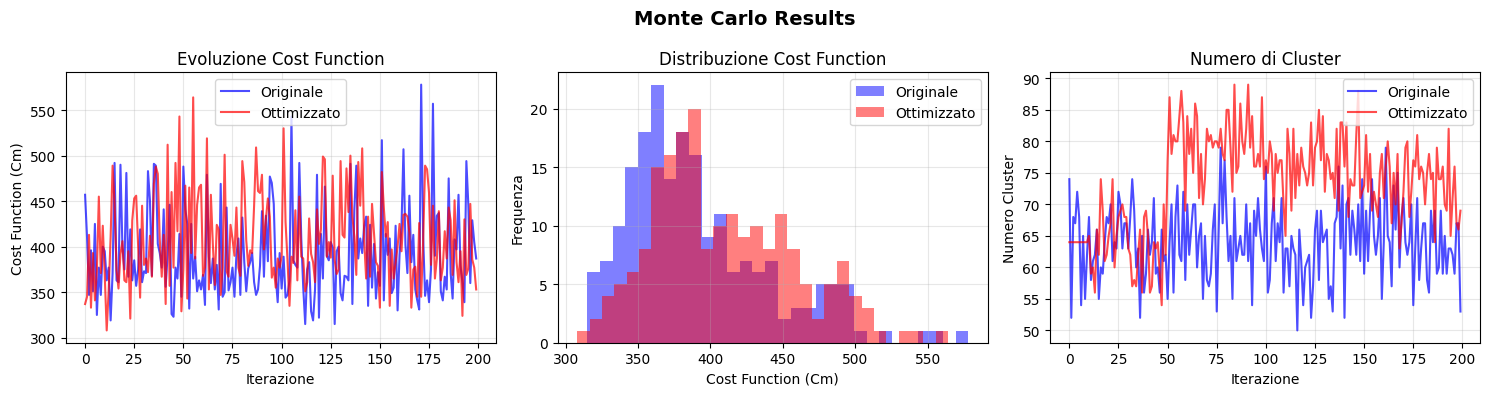


PLOT RISULTATI GENETIC ALGORITHM
Grafici salvati in 'GA_optimization_results.png'


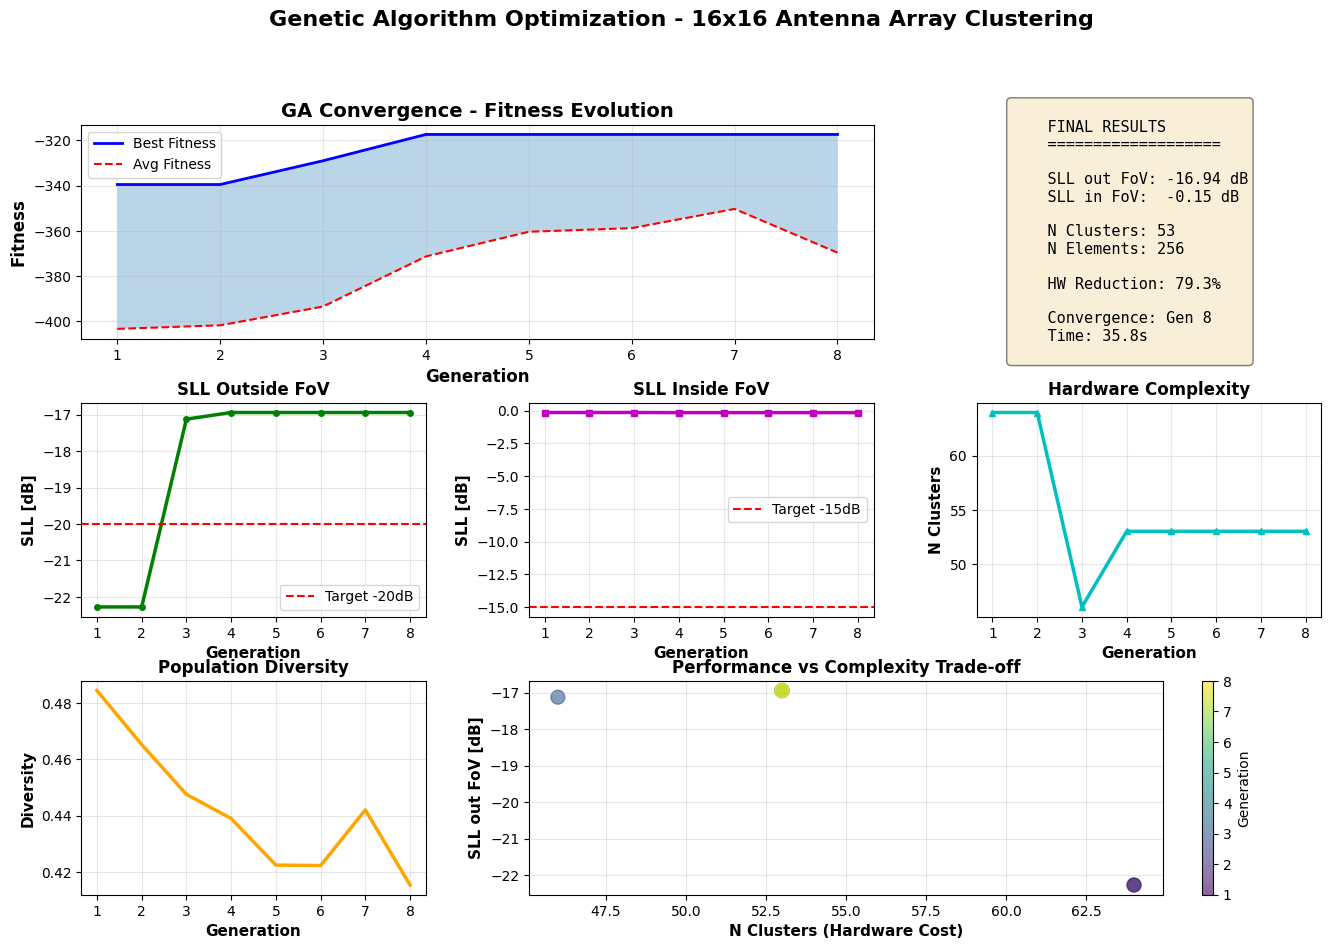

In [135]:
# ============================================================
# ESEGUI TUTTI I PLOT
# ============================================================

print("="*70)
print("PLOT RISULTATI MONTE CARLO")
print("="*70)
plot_mc_results(results_original, results_optimized)

print("\n" + "="*70)
print("PLOT RISULTATI GENETIC ALGORITHM")
print("="*70)
plot_ga_results(ga_optimizer)

In [136]:
# ============================================================
# CONFRONTO FINALE MC vs GA
# ============================================================

def get_best_mc_solution(results):
    """Estrai migliore soluzione MC"""
    if results['n_valid_solutions'] == 0:
        return None
    return min(results['simulation'], key=lambda x: x['Cm'])

best_mc_orig = get_best_mc_solution(results_original)
best_mc_opt = get_best_mc_solution(results_optimized)
best_ga = ga_optimizer.best_individual

print("="*70)
print("CONFRONTO FINALE: MONTE CARLO vs GENETIC ALGORITHM")
print("="*70)
print()
print(f"{'Metrica':<25} {'MC Original':>15} {'MC Optimized':>15} {'GA':>15}")
print("-"*70)

if best_mc_orig and best_mc_opt and best_ga:
    print(f"{'Cost Function (Cm)':<25} {best_mc_orig['Cm']:>15d} {best_mc_opt['Cm']:>15d} {best_ga['Cm']:>15d}")
    print(f"{'Best SLL out (dB)':<25} {best_mc_orig['sll_out']:>15.2f} {best_mc_opt['sll_out']:>15.2f} {best_ga['sll_out']:>15.2f}")
    print(f"{'Best SLL in (dB)':<25} {best_mc_orig['sll_in']:>15.2f} {best_mc_opt['sll_in']:>15.2f} {best_ga['sll_in']:>15.2f}")
    print(f"{'N Clusters':<25} {best_mc_orig['Ntrans']:>15d} {best_mc_opt['Ntrans']:>15d} {best_ga['n_clusters']:>15d}")
    print(f"{'Tempo (s)':<25} {results_original['elapsed_time']:>15.1f} {results_optimized['elapsed_time']:>15.1f} {ga_optimizer.elapsed_time:>15.1f}")
    print(f"{'Iterazioni/Generazioni':<25} {NITER:>15d} {NITER:>15d} {len(ga_optimizer.history['best_Cm']):>15d}")
else:
    print("Alcune soluzioni non disponibili")

print()
print("="*70)
print("CONCLUSIONE:")
winner_cm = min([
    ("MC Original", best_mc_orig['Cm'] if best_mc_orig else 99999),
    ("MC Optimized", best_mc_opt['Cm'] if best_mc_opt else 99999),
    ("GA", best_ga['Cm'] if best_ga else 99999)
], key=lambda x: x[1])
print(f"VINCITORE (miglior Cm): {winner_cm[0]} con Cm = {winner_cm[1]}")
print("="*70)

CONFRONTO FINALE: MONTE CARLO vs GENETIC ALGORITHM

Metrica                       MC Original    MC Optimized              GA
----------------------------------------------------------------------
Cost Function (Cm)                    315             308             307
Best SLL out (dB)                  -19.15          -20.44          -16.94
Best SLL in (dB)                    -0.14           -0.15           -0.15
N Clusters                             57              59              53
Tempo (s)                            71.5            83.2            35.8
Iterazioni/Generazioni                200             200               8

CONCLUSIONE:
VINCITORE (miglior Cm): GA con Cm = 307


## 14.1 Lobe Analysis (SLL, HPBW) - come regular folder

Analisi dettagliata dei lobi come nel folder regular/opt/grid_search:
- Side Lobe Level (SLL) relativo in elevation e azimuth
- Half Power Beam Width (HPBW)
- Numero di lobi laterali
- Confronto tra le migliori soluzioni

LOBE ANALYSIS - Monte Carlo Original (Best Solution)
Plot salvato in lobe_analysis_mc_orig.png


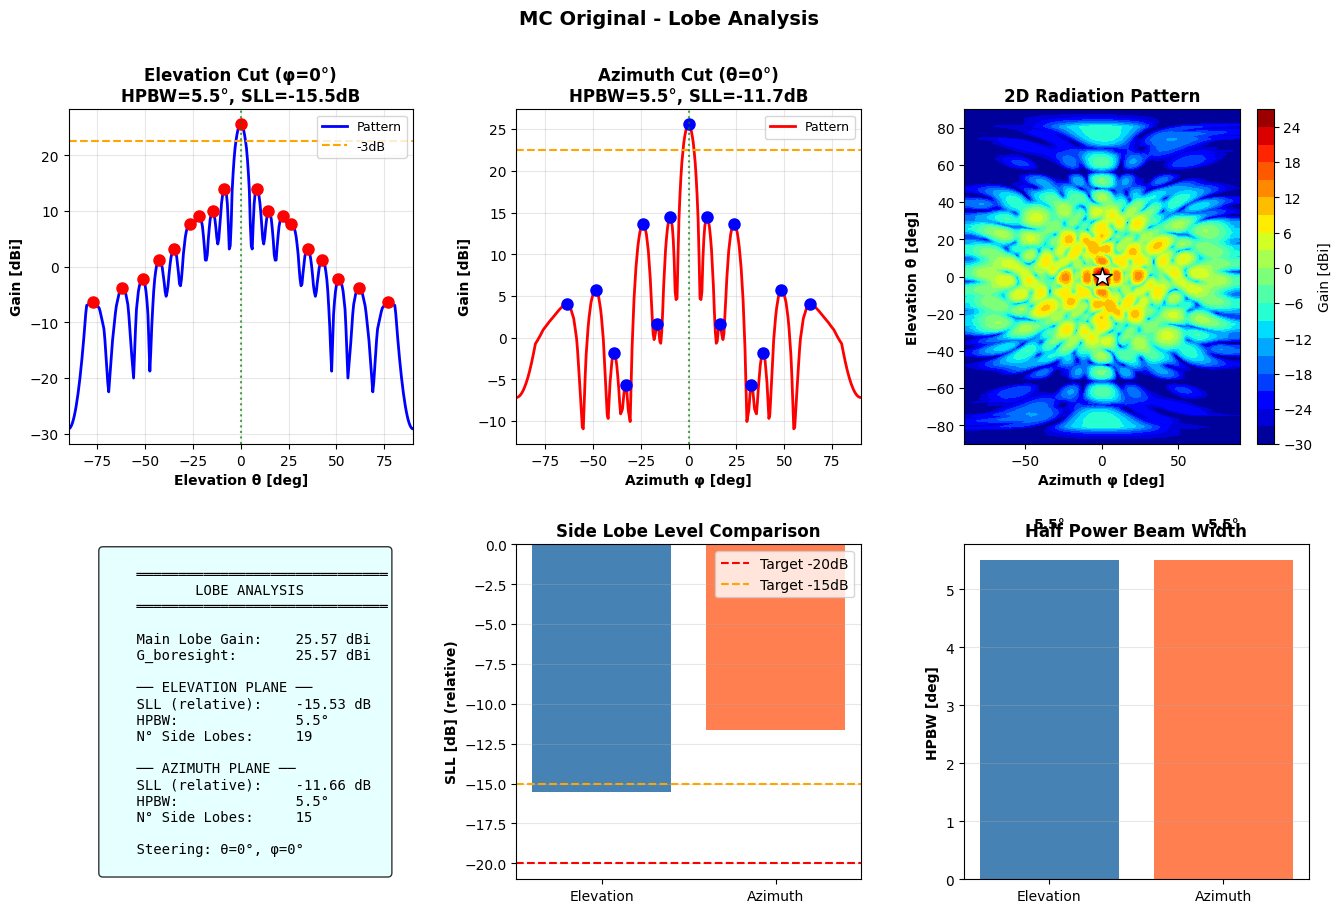


LOBE ANALYSIS - Monte Carlo Optimized (Best Solution)
Plot salvato in lobe_analysis_mc_opt.png


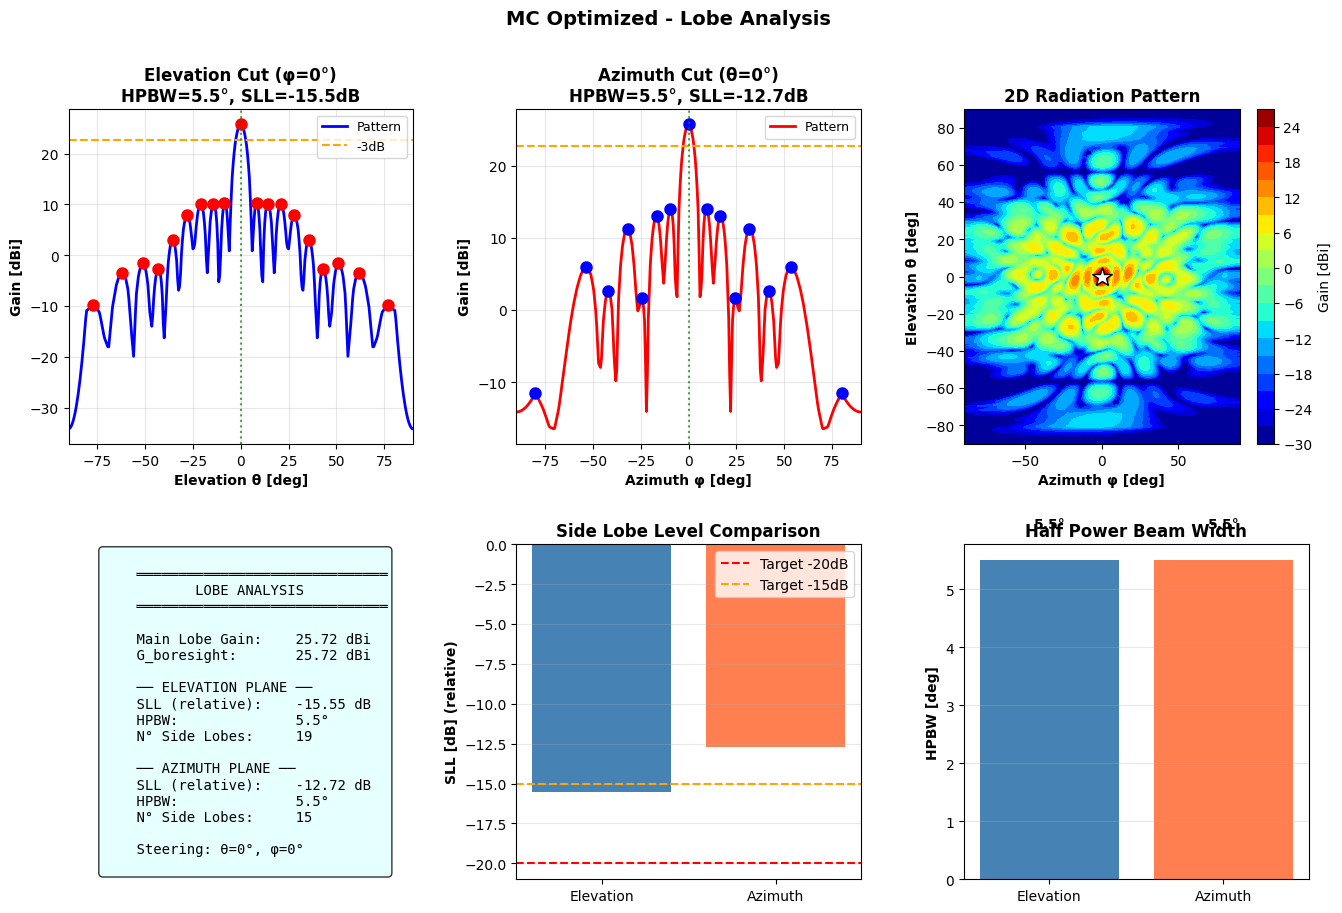


LOBE ANALYSIS - Genetic Algorithm (Best Solution)
Plot salvato in lobe_analysis_ga.png


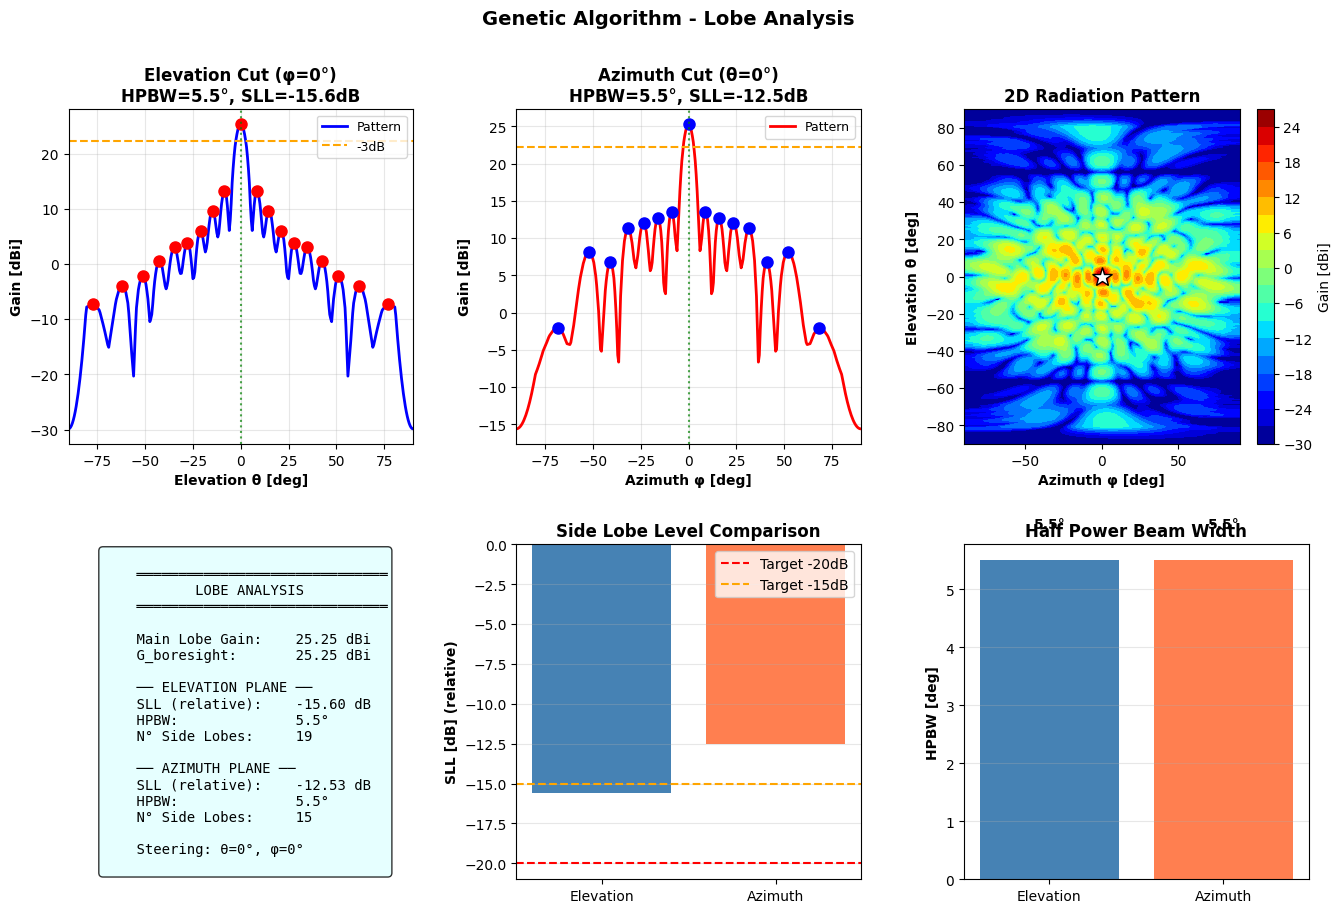

In [137]:
# ============================================================
# LOBE ANALYSIS - Analisi Lobi per tutte le migliori soluzioni
# ============================================================

def rows_to_clusters(selected_rows, optimizer):
    """Converte selected_rows in lista Cluster usando i dati dell'optimizer"""
    clusters = []
    offset = 0
    for bb, S in enumerate(optimizer.S_all):
        Nsub = optimizer.N_all[bb]
        for idx in range(Nsub):
            if selected_rows[offset + idx] == 1:
                clusters.append(S[idx])
        offset += Nsub
    return clusters

def genes_to_clusters(genes, ga_optimizer):
    """Converte genes (GA) in lista Cluster usando i dati del GA optimizer"""
    # GA usa lo stesso subarray set
    clusters = []
    offset = 0
    for bb, S in enumerate(ga_optimizer.S_all):
        Nsub = ga_optimizer.N_all[bb]
        for idx in range(Nsub):
            if genes[offset + idx] == 1:
                clusters.append(S[idx])
        offset += Nsub
    return clusters

def get_ff_i_db_mc(solution, antenna_array, optimizer):
    """Ottieni FF_I_dB da una soluzione MC"""
    if 'FF_I_dB' in solution:
        return solution['FF_I_dB'], solution.get('G_boresight')
    
    if 'selected_rows' in solution:
        Cluster = rows_to_clusters(solution['selected_rows'], optimizer)
        if len(Cluster) > 0:
            result = antenna_array.evaluate_clustering(Cluster)
            return result['FF_I_dB'], result['G_boresight']
    
    return None, None

def get_ff_i_db_ga(solution, antenna_array, ga_opt):
    """Ottieni FF_I_dB da una soluzione GA"""
    if 'FF_I_dB' in solution:
        return solution['FF_I_dB'], solution.get('G_boresight')
    
    if 'genes' in solution:
        Cluster = genes_to_clusters(solution['genes'], ga_opt)
        if len(Cluster) > 0:
            result = antenna_array.evaluate_clustering(Cluster)
            return result['FF_I_dB'], result['G_boresight']
    
    return None, None

print("="*70)
print("LOBE ANALYSIS - Monte Carlo Original (Best Solution)")
print("="*70)

mc_orig_metrics = None
if best_mc_orig:
    ff_i_db, g_bore = get_ff_i_db_mc(best_mc_orig, array, optimizer_original)
    if ff_i_db is not None:
        mc_orig_metrics = plot_lobe_analysis(
            ff_i_db, array, 
            G_boresight=g_bore,
            title='MC Original - Lobe Analysis',
            save_path='lobe_analysis_mc_orig.png'
        )
    else:
        print("Impossibile calcolare FF_I_dB per MC Original")

print("\n" + "="*70)
print("LOBE ANALYSIS - Monte Carlo Optimized (Best Solution)")
print("="*70)

mc_opt_metrics = None
if best_mc_opt:
    ff_i_db, g_bore = get_ff_i_db_mc(best_mc_opt, array, optimizer_optimized)
    if ff_i_db is not None:
        mc_opt_metrics = plot_lobe_analysis(
            ff_i_db, array,
            G_boresight=g_bore,
            title='MC Optimized - Lobe Analysis',
            save_path='lobe_analysis_mc_opt.png'
        )
    else:
        print("Impossibile calcolare FF_I_dB per MC Optimized")

print("\n" + "="*70)
print("LOBE ANALYSIS - Genetic Algorithm (Best Solution)")
print("="*70)

ga_metrics = None
if best_ga:
    ff_i_db, g_bore = get_ff_i_db_ga(best_ga, array, ga_optimizer)
    if ff_i_db is not None:
        ga_metrics = plot_lobe_analysis(
            ff_i_db, array,
            G_boresight=g_bore,
            title='Genetic Algorithm - Lobe Analysis',
            save_path='lobe_analysis_ga.png'
        )
    else:
        print("Impossibile calcolare FF_I_dB per GA")

CONFRONTO LOBI - MC Original vs MC Optimized vs GA
Plot salvato in lobe_comparison_all.png


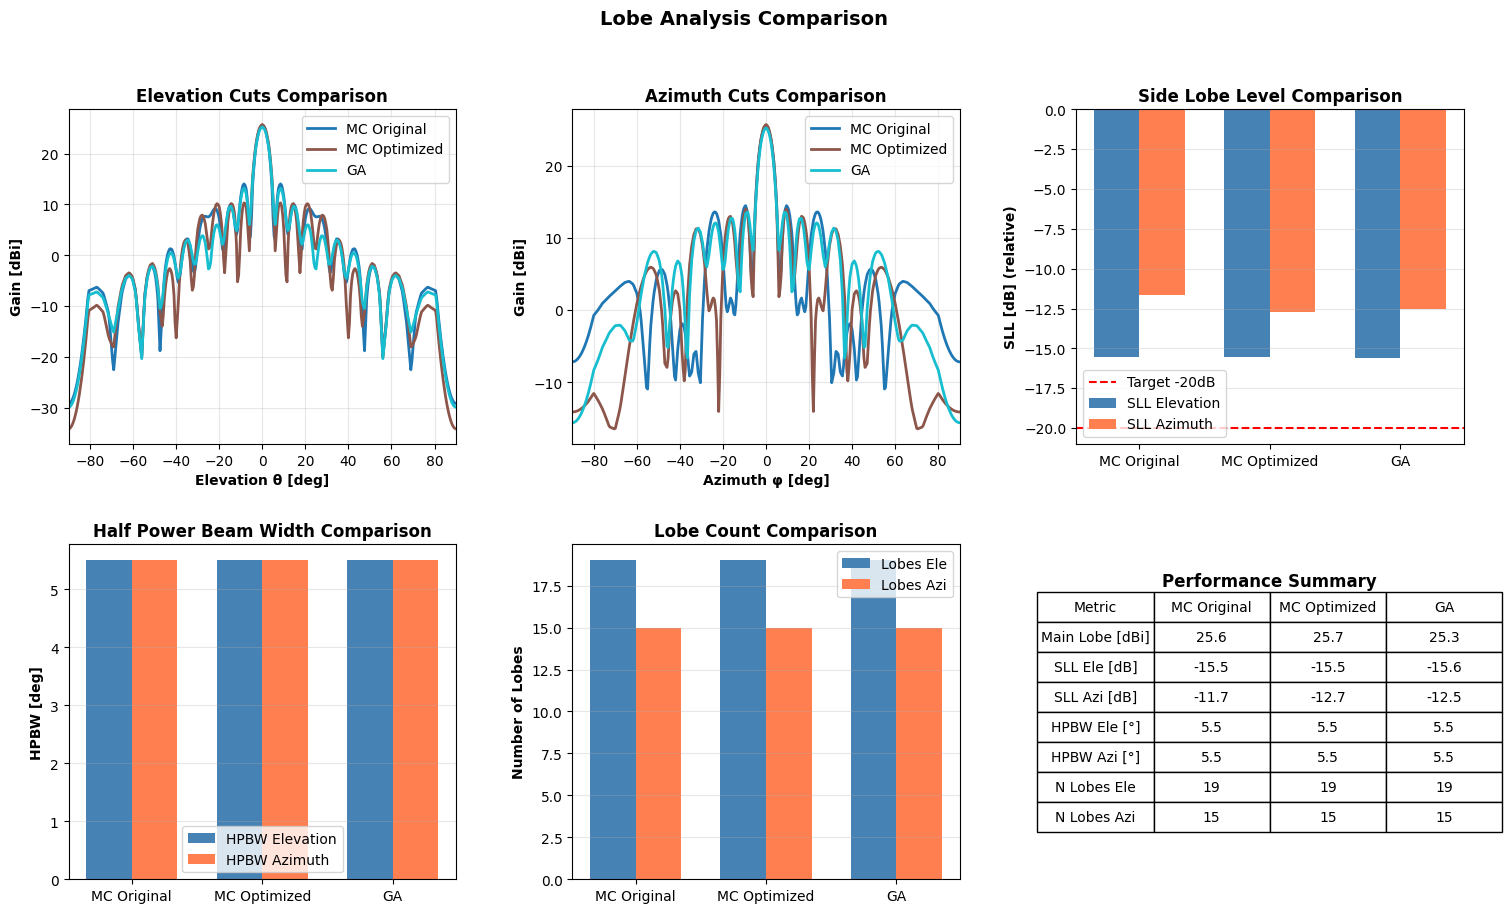


TABELLA RIEPILOGATIVA LOBI

Metrica                      MC Original   MC Optimized             GA
----------------------------------------------------------------------
Main Lobe [dBi]                    25.57          25.72          25.25
SLL Ele [dB]                      -15.53         -15.55         -15.60
SLL Azi [dB]                      -11.66         -12.72         -12.53
HPBW Ele [°]                        5.50           5.50           5.50
HPBW Azi [°]                        5.50           5.50           5.50
N Lobes Ele                           19             19             19
N Lobes Azi                           15             15             15


In [138]:
# ============================================================
# CONFRONTO LOBI TRA TUTTE LE SOLUZIONI
# ============================================================

print("="*70)
print("CONFRONTO LOBI - MC Original vs MC Optimized vs GA")
print("="*70)

# Prepara lista di risultati per il confronto (con FF_I_dB calcolato)
results_to_compare = []
labels_to_compare = []

if best_mc_orig:
    ff_i_db, g_bore = get_ff_i_db_mc(best_mc_orig, array, optimizer_original)
    if ff_i_db is not None:
        result_copy = dict(best_mc_orig)
        result_copy['FF_I_dB'] = ff_i_db
        result_copy['G_boresight'] = g_bore
        results_to_compare.append(result_copy)
        labels_to_compare.append('MC Original')

if best_mc_opt:
    ff_i_db, g_bore = get_ff_i_db_mc(best_mc_opt, array, optimizer_optimized)
    if ff_i_db is not None:
        result_copy = dict(best_mc_opt)
        result_copy['FF_I_dB'] = ff_i_db
        result_copy['G_boresight'] = g_bore
        results_to_compare.append(result_copy)
        labels_to_compare.append('MC Optimized')

if best_ga:
    ff_i_db, g_bore = get_ff_i_db_ga(best_ga, array, ga_optimizer)
    if ff_i_db is not None:
        result_copy = dict(best_ga)
        result_copy['FF_I_dB'] = ff_i_db
        result_copy['G_boresight'] = g_bore
        results_to_compare.append(result_copy)
        labels_to_compare.append('GA')

if len(results_to_compare) >= 2:
    comparison_metrics = plot_lobe_comparison(
        results_to_compare, labels_to_compare, array,
        save_path='lobe_comparison_all.png'
    )
    
    print("\n" + "="*70)
    print("TABELLA RIEPILOGATIVA LOBI")
    print("="*70)
    print(f"\n{'Metrica':<25}", end='')
    for label in labels_to_compare:
        print(f"{label:>15}", end='')
    print()
    print("-"*70)
    
    for i, metric_name in enumerate(['main_lobe_gain', 'sll_ele_relative', 'sll_azi_relative', 
                                      'hpbw_ele', 'hpbw_azi', 'n_lobes_ele', 'n_lobes_azi']):
        label_map = {
            'main_lobe_gain': 'Main Lobe [dBi]',
            'sll_ele_relative': 'SLL Ele [dB]',
            'sll_azi_relative': 'SLL Azi [dB]',
            'hpbw_ele': 'HPBW Ele [°]',
            'hpbw_azi': 'HPBW Azi [°]',
            'n_lobes_ele': 'N Lobes Ele',
            'n_lobes_azi': 'N Lobes Azi'
        }
        print(f"{label_map[metric_name]:<25}", end='')
        for m in comparison_metrics:
            val = m[metric_name]
            if isinstance(val, float):
                print(f"{val:>15.2f}", end='')
            else:
                print(f"{val:>15d}", end='')
        print()
else:
    print("Non ci sono abbastanza soluzioni per il confronto")

## 14. Conclusioni

**Algoritmi implementati:**

### Monte Carlo (MC)
1. **Greedy initialization** (iter 1-10): Costruisce soluzioni iniziali selezionando cluster non sovrapposti
2. **Local search** (su soluzioni promettenti): Migliora flip-by-flip le soluzioni buone
3. **Adaptive sampling** (iter 51+): I cluster che appaiono in buone soluzioni hanno maggiore probabilità
4. **NumPy vectorization**: Kernel computation ottimizzato

### Genetic Algorithm (GA)
1. **Popolazione evolve**: Soluzioni migliori sopravvivono e si riproducono
2. **Crossover**: Combina geni di due genitori per creare figli
3. **Mutazione**: Introduce variabilità flippando bit random
4. **Elite selection**: I migliori individui passano direttamente alla generazione successiva

**Entrambi gli algoritmi usano calcoli FFT REALI per valutare le soluzioni!**

Il GA mostra convergenza vera (fitness migliora generazione dopo generazione), mentre MC fa sampling statistico dello spazio soluzioni.